In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from math import gamma
from TLPP_Generation import Logic_Model_Generator
from tqdm import *
import itertools
import scienceplots
plt.style.use(['science','no-latex','grid'])

class LSTM_Encoding_Action(nn.Module):

    '''
    input: [batch_size, num_predicate, seq_length]
    Parameters:
        input_size:
        hidden_size:
        output_size:
        num_layers:
    '''

    def __init__(self, input_size, hidden_size, output_size, batch_size, device, num_layers:int = 1) -> None:
        super().__init__()

        self.device = device
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_directions = 1 # one-directional LSTM
        self.batch_size = batch_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x:torch.tensor):
        batch_size, num_predicate, seq_length = x.shape
        h_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(self.device)
        c_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(self.device)
        x, _  = self.lstm(x, (h_0, c_0)) #NOTE: x:(batch_size, seq_length, num_directions * hidden_size)
        x = self.linear(x)
        x = x.view(batch_size, num_predicate, -1)
        return x


class LSTM_Encoding_History(nn.Module):

    '''
    NOTE:Returns a categorical distribution

    Parameters:
        input_size:
        hidden_size:
        output_size:
        num_layers
    '''

    def __init__(self, input_size, hidden_size, output_size, batch_size, device, num_layers: int = 1) -> None:
        super().__init__()

        self.device = device
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_directions = 1 # one-directional LSTM
        self.batch_size = batch_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x:torch.tensor, action_embedding: torch.tensor):
        '''
        Parameters:
            x: mental history
            action_embedding: encoding of action history. This should be the output of LSTM_Encoding_Action
        '''
        batch_size, num_predicate, seq_length = x.shape
        h_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(self.device)
        c_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(self.device)
        x, _ = self.lstm(x,(h_0,c_0))                              #NOTE: x:(batch_size, seq_length, num_directions * hidden_size)
        x = torch.concat(tensors=[x, action_embedding], dim=1)     #NOTE: concatenate the action info and the mental info
        batch_size, num_predicate, hidden_size = x.shape           #NOTE: num_predicate is changed
        x = self.linear(x)                                         #NOTE: x:(batch_size, seq_length, num_directions * output_size)
        x = x.view(batch_size, num_predicate, -1)
        #TODO: return a vector with dimension (I+1), (I represents the number of types of mental states)
        #TODO: the i-th (i=0,1,2,...,I) component of the output x represents the probability of the i-th mental type
        x = self.softmax(x)
        return x.view(batch_size,-1,self.output_size).mean(axis=1)
        

class Logic_Model_Incomplete_Data:

    def __init__(self, time_horizon:float, action_history:dict, hidden_size:tuple, output_size:tuple, batch_size:int, partition_size:float=0.1, device:str='cuda', num_layers:tuple=(1,1)) -> None:
        self.time_horizon = time_horizon
        self.partition_size = partition_size            # num of small time intervals
        self.action_history = action_history
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.device = device
        self.num_layers = num_layers                    # num_layers of LSTMs
        #TODO:
        ### the following parameters are used to manually define the logic rules
        self.num_predicate = 7                  # num_predicate is same as num_node
        self.num_formula = 8                    # num of prespecified logic rules
        self.BEFORE = 'BEFORE'
        self.EQUAL = 'EQUAL'
        self.AFTER = 'AFTER'
        self.Time_tolerance = 0.3               
        self.body_predicate_set = []                        # the index set of all body predicates
        self.mental_predicate_set = [0, 1, 2]
        self.action_predicate_set = [3, 4, 5, 6]
        self.head_predicate_set = [0, 1, 2, 3, 4, 5, 6]     # the index set of all head predicates
        self.decay_rate = 1                                 # decay kernel
        self.integral_resolution = 0.03

        #TODO: convert the action_history:dict to a numpy array 'processed_data':np.array to put in the LSTMs
        self.processed_data = self.process_data(action_history=self.action_history).to(device)
        self.INPUT_SIZE_A = self.processed_data.shape[-1]
        #self.INPUT_SIZE_M = int(self.time_horizon / self.partition_size)

        #TODO: construct two LSTMs to encode the past history
        #NOTE: encoding action history
        self.LSTM_Action = LSTM_Encoding_Action(input_size=self.INPUT_SIZE_A,hidden_size=hidden_size[0],output_size=output_size[0],batch_size=batch_size,device=device,num_layers=self.num_layers[0])
        self.LSTM_Action.to(device)
        #NOTE: encoding whole history
        self.LSTM_History = LSTM_Encoding_History(input_size=len(self.mental_predicate_set),hidden_size=hidden_size[1],output_size=output_size[1],batch_size=batch_size ,device=device,num_layers=self.num_layers[1])
        self.LSTM_History.to(device)


        ### the following parameters are used to generate synthetic data
        ### for the learning part, the following is used to claim variables
        ### self.model_parameter = {0:{},1:{},...,6:{}}
        self.model_parameter = {}


        '''
        mental
        '''

        head_predicate_idx = 0
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.3).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.01).double(), requires_grad=True)
        formula_idx = 1
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.01).double(), requires_grad=True)

        head_predicate_idx = 1
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.3).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.02).double(), requires_grad=True)
        formula_idx = 1
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.01).double(), requires_grad=True)

        head_predicate_idx = 2
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.2).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.1).double(), requires_grad=True)


        '''
        action
        '''
        head_predicate_idx = 3
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.1).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.01).double(), requires_grad=True)

        head_predicate_idx = 4
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.25).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.05).double(), requires_grad=True)

        head_predicate_idx = 5
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.6).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.8).double(), requires_grad=True)

        head_predicate_idx = 6
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.1).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.05).double(), requires_grad=True)




        #NOTE: set the content of logic rules
        self.logic_template = self.logic_rule()
    
    def logic_rule(self):
        #TODO: the logic rules encode the prior knowledge
        # encode rule information
        '''
        This function encodes the content of logic rules
        logic_template = {0:{},1:{},...,6:{}}
        '''
        logic_template = {}


        '''
        Mental (0-2)
        '''

        head_predicate_idx = 0
        logic_template[head_predicate_idx] = {} # here 0 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (2 and 3 and 4) and before(2,0) and before(3,0) and before(4,0) \to 0
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [2,3,4]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1, 1, 1]  # use 1 to indicate True; use -1 to indicate False
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[2, 0], [3, 0], [4, 0]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE, self.BEFORE, self.BEFORE]


        #NOTE: rule content: ((\neg 0 and (2 and 6)) and after(6,0) and equal(2,0) \to \neg 0)
        formula_idx = 1
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [0, 2, 6]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [-1, 1, 1]  # use 1 to indicate True; use -1 to indicate False
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [-1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[6, 0], [2, 0]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.AFTER, self.EQUAL]

        head_predicate_idx = 1
        logic_template[head_predicate_idx] = {}  # here 1 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: 5 and before(5,1) to 1
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [5]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[5, 1]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE]

        #NOTE: rule content: (4 and 6) and before(6,1) to \neg 1
        formula_idx = 1
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [4, 6]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1, 1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [-1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[6, 1]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE]


        head_predicate_idx = 2
        logic_template[head_predicate_idx] = {}  # here 2 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (\neg 1 and 6) and after(1,2) to 2
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [1, 6]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [-1, 1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[1, 2]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.AFTER]



        '''
        Action (3-6)
        '''
        head_predicate_idx = 3
        logic_template[head_predicate_idx] = {}  # here 3 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (0 and \neg 1) and before(0,1) and before(1,3) \to 3
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [0, 1]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1, -1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[0, 1], [1, 3]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE, self.BEFORE]


        head_predicate_idx = 4
        logic_template[head_predicate_idx] = {}  # here 4 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (2) and before(2,4) \to 4
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [2]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[2, 4]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE]

        
        head_predicate_idx = 5
        logic_template[head_predicate_idx] = {}  # here 5 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (0 and \neg 1) and before(0,5) and after(1,5) \to 5
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [0, 1]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1, -1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[0, 5], [1, 5]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE, self.AFTER]


        head_predicate_idx = 6
        logic_template[head_predicate_idx] = {}  # here 6 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (1 and 2) and before(1,6) and before(2,6) \to \neg 6
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [1, 2]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1, 1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [-1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[1, 6], [2, 6]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE, self.BEFORE]


        return logic_template

    def intensity(self, cur_time, head_predicate_idx, history)->torch.tensor:
        feature_formula = []
        weight_formula = []
        effect_formula = []
        #TODO: Check if the head_prediate is a mental predicate
        if head_predicate_idx in self.mental_predicate_set: flag = 0
        else: flag = 1  #NOTE: action

        for formula_idx in list(self.logic_template[head_predicate_idx].keys()):
            weight_formula.append(self.model_parameter[head_predicate_idx][formula_idx]['weight'])

            feature_formula.append(self.get_feature(cur_time=cur_time, head_predicate_idx=head_predicate_idx,
                                                    history=history, template=self.logic_template[head_predicate_idx][formula_idx], flag=flag))
            effect_formula.append(self.get_formula_effect(cur_time=cur_time, head_predicate_idx=head_predicate_idx,
                                                       history=history, template=self.logic_template[head_predicate_idx][formula_idx]))
        intensity = torch.exp(torch.cat(weight_formula, dim=0)) * torch.cat(feature_formula, dim=0) * torch.cat(effect_formula, dim=0)
        intensity = self.model_parameter[head_predicate_idx]['base'] + torch.sum(intensity)
        intensity = torch.exp(intensity)

        return intensity

    def get_feature(self, cur_time, head_predicate_idx, history, template, flag:int):
        #NOTE: flag: 0 or 1, denotes the head_predicate_idx is a mental or an action
        #NOTE: 0 for mental and 1 for action
        #NOTE: since for mental, we need to go through all the history information
        #NOTE: while for action, we only care about the current time information
        
        transition_time_dic = {}
        feature = torch.tensor([0], dtype=torch.float64)
        for idx, body_predicate_idx in enumerate(template['body_predicate_idx']):
            transition_time = np.array(history[body_predicate_idx]['time'])
            transition_state = np.array(history[body_predicate_idx]['state'])
            mask = (transition_time <= cur_time) * (transition_state == template['body_predicate_sign'][idx])
            transition_time_dic[body_predicate_idx] = transition_time[mask]
        transition_time_dic[head_predicate_idx] = [cur_time]
        ### get weights
        # compute features whenever any item of the transition_item_dic is nonempty
        history_transition_len = [len(i) for i in transition_time_dic.values()]
        if min(history_transition_len) > 0:
            # need to compute feature using logic rules
            time_combination = np.array(list(itertools.product(*transition_time_dic.values())))
            time_combination_dic = {}
            for i, idx in enumerate(list(transition_time_dic.keys())):
                #TODO: this is where we distinguish mental and action
                time_combination_dic[idx] = time_combination[:, i] if flag == 0 else time_combination[-1, i]
            temporal_kernel = np.ones(len(time_combination))
            for idx, temporal_relation_idx in enumerate(template['temporal_relation_idx']):       
                #TODO: checkpoint
                #print('head_predicate_idx: {}; temporal_relation_idx[0]: {}, temporal_relation_idx[1]: {}'.format(head_predicate_idx, temporal_relation_idx[0], temporal_relation_idx[1]))
                #print('temporal combination dict: {}'.format(time_combination_dic))
         
                time_difference = time_combination_dic[temporal_relation_idx[0]] - time_combination_dic[temporal_relation_idx[1]]
                if template['temporal_relation_type'][idx] == 'BEFORE':
                    temporal_kernel *= (time_difference < - self.Time_tolerance) * np.exp(-self.decay_rate *(cur_time - time_combination_dic[temporal_relation_idx[0]]))
                if template['temporal_relation_type'][idx] == 'EQUAL':
                    temporal_kernel *= (abs(time_difference) <= self.Time_tolerance) * np.exp(-self.decay_rate*(cur_time - time_combination_dic[temporal_relation_idx[0]]))
                if template['temporal_relation_type'][idx] == 'AFTER':
                    temporal_kernel *= (time_difference > self.Time_tolerance) * np.exp(-self.decay_rate*(cur_time - time_combination_dic[temporal_relation_idx[1]]))
            feature = torch.tensor([np.sum(temporal_kernel)], dtype=torch.float64)
        return feature

    def get_formula_effect(self, cur_time, head_predicate_idx, history, template):
        ## Note this part is very important!! For generator, this should be np.sum(cur_time > head_transition_time) - 1
        ## Since at the transition times, choose the intensity function right before the transition time
        head_transition_time = np.array(history[head_predicate_idx]['time'])
        head_transition_state = np.array(history[head_predicate_idx]['state'])
        if len(head_transition_time) == 0:
            cur_state = 0
            counter_state = 1 - cur_state
        else:
            idx = np.sum(cur_time > head_transition_time) - 1
            cur_state = head_transition_state[idx]
            counter_state = 1 - cur_state
        if counter_state == template['head_predicate_sign']:
            formula_effect = torch.tensor([1], dtype=torch.float64)
        else:
            formula_effect = torch.tensor([-1], dtype=torch.float64)
        return formula_effect

    def log_likelihood(self, dataset, sample_ID_batch, T_max)->torch.tensor:
        '''
        This function calculates the log-likehood given the dataset
        log-likelihood = \sum log(intensity(transition_time)) + int_0^T intensity dt

        Parameters:
            dataset: 
            sample_ID_batch: list
            T_max:
        '''
        log_likelihood = torch.tensor([0], dtype=torch.float64)
        # iterate over samples
        for sample_ID in sample_ID_batch:
            # iterate over head predicates; each predicate corresponds to one intensity
            data_sample = dataset[sample_ID]
            for head_predicate_idx in self.head_predicate_set:
                #NOTE: compute the summation of log intensities at the transition times
                intensity_log_sum = self.intensity_log_sum(head_predicate_idx, data_sample)
                #NOTE: compute the integration of intensity function over the time horizon
                intensity_integral = self.intensity_integral(head_predicate_idx, data_sample, T_max)
                log_likelihood += (intensity_log_sum - intensity_integral)
        return log_likelihood

    def intensity_log_sum(self, head_predicate_idx, data_sample):
        intensity_transition = []
        for t in data_sample[head_predicate_idx]['time'][1:]:
            #NOTE: compute the intensity at transition times
            cur_intensity:torch.tensor = self.intensity(t, head_predicate_idx, data_sample)
            intensity_transition.append(cur_intensity)
        if len(intensity_transition) == 0: # only survival term, no event happens
            log_sum = torch.tensor([0], dtype=torch.float64)
        else:
            log_sum = torch.sum(torch.log(torch.cat(intensity_transition, dim=0)))
        return log_sum

    def intensity_integral(self, head_predicate_idx, data_sample, T_max):
        start_time = 0
        end_time = T_max
        intensity_grid = []
        for t in np.arange(start_time, end_time, self.integral_resolution):
            #NOTE: evaluate the intensity values at the chosen time points
            cur_intensity:torch.Tensor = self.intensity(t, head_predicate_idx, data_sample)
            intensity_grid.append(cur_intensity)
        #NOTE: approximately calculate the integral
        integral = torch.sum(torch.cat(intensity_grid, dim=0) * self.integral_resolution)
        return integral

    def process_data(self, action_history:dict)->torch.tensor:
        '''
        Parameters:
            action_history: dict
        '''
        #TODO: convert the action sequences into a numpy array
        #NOTE: action_history = {
        #                       3: {...}
        #                       4: {...}
        #                       5: {...}
        #                       6: {...}
        #                       }
        # "..." stands for transition times for predicate 3,4,5,6. Recall that 3,4,5,6 are all action predicates
        result = []
        max_action_transition_time_length = 0       #NOTE: record the length of the transition time
        for sample_id in action_history:            #NOTE: batch
            for action_predicate_idx in self.action_predicate_set:
                #print(sample_id, action_predicate_idx)
                time = action_history[sample_id][action_predicate_idx]['time'][1:]
                tmp = len(time)
                if tmp > max_action_transition_time_length: max_action_transition_time_length = tmp
                result.append(time)
        #print(result)
        #NOTE: shape (batch_size:len(action_history), num_predicate:len(self.action_predicate_set), seq_length:max_action_transition_time_length)
        data = np.zeros(shape=(len(action_history),len(self.action_predicate_set),max_action_transition_time_length))
        #TODO: store the action history in a tensor
        for batch in range(data.shape[0]):
            for row in range(data.shape[1]): 
                data[batch, row, :len(result[(batch+1)*row])] = result[(batch+1)*row]
        return torch.tensor(data).float()

    def ELBO(self, sample_ID_batch:list, temperature:float=1.0, device='cuda')->torch.tensor:
        #TODO: compute the ELBO. 
        #TODO: Maximize the ELBO is equivalent to minimize the KL divergence between the variational posterior and the true posterior
        #NOTE: in order to compute the ELBO, we need to 1. be able to sample from the variational posterior; 2. compute the entropy of q
        
        '''
        compute the ELBO (MC estimate)

        Parameters:
            sample_ID_batch: the collection of batch indices
            action_history: action information
            temperature: 
        '''
        #NOTE: we add a small time shift 1e-4 so that we can include the end time point in 'time_intervals'
        time_intervals = np.arange(0,self.time_horizon+1e-4,step=self.partition_size)
        #print(time_intervals) #NOTE: checkpoint

        #TODO: initialize. Store the complete data
        complete_history = dict([(sample_id, self.action_history[sample_id]) for sample_id in sample_ID_batch])
        for sample_id in complete_history:
            for mental_predicate_idx in self.mental_predicate_set:
                complete_history[sample_id][mental_predicate_idx] = {}
                complete_history[sample_id][mental_predicate_idx]['time'] = [0]
                complete_history[sample_id][mental_predicate_idx]['state'] = [0]
        #print(complete_history) #NOTE: checkpoint
        #TODO: initilize, store mental history, this will be fed into the LSTM
        mental_history = torch.zeros(size=(len(sample_ID_batch),1,len(self.mental_predicate_set))).to(device)

        ELBO = (torch.zeros(size=(1,self.batch_size))).to(device)    #NOTE: initialize ELBO
        
        #TODO: encode the mental history
        h_a = self.LSTM_Action.forward(self.processed_data[sample_ID_batch,:,:]) #h_a (batch_size, num_predicate, output_size=hidden_size_m)
        for i in range(len(time_intervals)-1):
            #TODO: encode the mental history before the i-th time interval (LSTMs) -> categorical distribution -> prob
            # prob (batch_size, 1, num_mental_predicate+1)
            prob:torch.tensor = self.LSTM_History.forward(x=mental_history,action_embedding=h_a)
            # logits (batch_size, 1, num_mental_predicate+1)
            logits:torch.tensor = torch.log(prob)
            #TODO: ELBO = ELBO + self.entropy_variational posterior
            ELBO += self.entropy_variational_posterior(logits,temperature,device=device)
            #TODO: draw hard samples. post_samples = self.sample_variational_posterior_hard(size = sample_size, prob = prob)
            post_samples:torch.tensor = self.sample_variational_posterior(size=len(sample_ID_batch),logits=logits,temperature=temperature,hard=True)
            #TODO: after sampling the mental transition time, update the history information
            event_time = (time_intervals[i] + time_intervals[i+1])/2
            _, indices = post_samples.max(dim=2)
            indices = indices.detach().cpu().numpy()
            new_mental_information = torch.zeros(size=(len(sample_ID_batch),1,len(self.mental_predicate_set))).to(device)
            
            #print(indices[0,:])
            for batch_idx in range(indices.shape[0]):
                for idx in indices[batch_idx,:]:
                    if idx == 0: continue
                    #TODO: update the mental history
                    new_mental_information[batch_idx,0,idx-1] = event_time
                    #TODO: update the complete history, which is a dict
                    sample_id = sample_ID_batch[batch_idx]
                    complete_history[sample_id][idx-1]['time'].append(event_time)
                    if complete_history[sample_id][idx-1]['state'][-1] == 0: complete_history[sample_id][idx-1]['state'].append(1)
                    else: complete_history[sample_id][idx-1]['state'].append(0)
            #print(new_mental_information) #NOTE:checkpoint
            #TODO: update mental_history
            mental_history = torch.concat([mental_history,new_mental_information],dim=1)
            
        #TODO: calculate mean of those ELBOs
        ELBO = torch.mean(ELBO).view(-1,)

        #TODO: ELBO += 1/L * (\sum log likelihood)
        ELBO += (self.log_likelihood(dataset=complete_history,sample_ID_batch=sample_ID_batch,T_max=self.time_horizon)).to(device)
        #print(ELBO) #NOTE: checkpoint
        #TODO: return ELBO
        return ELBO*len(self.action_history) #NOTE: \mathcal{L} * N

    def sample_variational_posterior(self, size:int, logits: torch.tensor, temperature:float=1.0, hard=False)->torch.tensor:
        #TODO: use gumbel-max trick to explicitly sample from the variational posterior defined by LSTMs, which is a categorical distribution
        '''
        draw explicit samples from variational posterior

        Parameters:
            size: number of samples
            logits: 
            hard: boolean
        '''
    
        result = []
        for i in range(size):
            tmp = self.gumbel_softmax(logits,temperature,hard)
            result.append(tmp)
        #NOTE: return one-hot vectors.
        #print(result)
        result = torch.stack(result,dim=0)
        return result

    def sample_Gumble(self, shape, eps:float=1e-20):
        #TODO: sample from Gumbel(0,1). This is needed when we want to explicitly sample from the variational posterior
        '''
        Sample from Gumbel(0,1) with shape = 'shape'

        Parameters:
            shape: 
            eps: small perturbation to avoid log(0)
            tens_type: 
        '''

        U = torch.rand(shape)
        U = U.cuda()
        return -torch.log(-torch.log(U+eps)+eps)

    def sample_Gumble_softmax(self, logits:torch.tensor, temperature=1.0):
        #TODO: sample from the gumbel-softmax distribution
        '''
        Parameters:
            prob: 
            temperature:
        '''
        y = logits + self.sample_Gumble(logits.shape)
        return F.softmax(y/temperature,dim=-1)

    def gumbel_softmax(self, logits:torch.tensor, temperature:float=1.0, hard=False):
        #TODO: ST-gumbel-softmax
        """
        ST-gumple-softmax
        input: [*, n_class]
        return: flatten --> [*, n_class] an one-hot vector
        """

        y = self.sample_Gumble_softmax(logits,temperature)
        if not hard: return y
        shape = y.size()
        _, idx = y.max(dim=-1)
        y_hard = torch.zeros_like(y).view(-1,shape[-1])
        y_hard.scatter_(1, idx.view(-1,1), 1)
        y_hard = y_hard.view(*shape)
        y_hard = (y_hard - y).detach() + y
        return y_hard

    def entropy_variational_posterior(self, logits:torch.tensor, temperature:float=1.0, MC_size:int=100, device='cuda')->float:
        #TODO: approximately calculate the entropy of the variational posterior
        #TODO: the true variational posterior (categorical) is approximated by a Gumbel-softmax distribution, controlled by 'tau' (temperature)
        '''
        Parameters:
            temperature: temperature parameter
            prob: probabilities for each category
        '''
        #TODO: draw 'MC_size' samples from gumble softmax distribution
        gumbel_softmax_samples = self.sample_variational_posterior(size=MC_size,logits=logits,temperature=temperature).to(device)
        #TODO: compute the log-densities
        log_densities = torch.log(self.Gumbel_softmax_density(gumbel_softmax_samples,temperature,logits)).to(device)
        #TODO: this is the Monte-Carlo estimate of the entropy
        result = torch.mean(-log_densities,dim=[0,-1])
        return result

    def Gumbel_softmax_density(self, y:torch.tensor, temperature:float, logits:torch.tensor)->torch.tensor:
        #TODO: return the probability density of Gumbel softmax distribution at y
        '''
        Parameters:
            y: input
            temperature: temperature parameter
            prob: probabilities for each category
        '''
        k = logits.size()[-1]
        prob = torch.exp(logits)
        #NOTE: compute the probability density. RHS is the density of gumbel softmax distribution
        result = gamma(k) * (temperature)**(k-1) * (torch.multiply(prob,1/(y)**temperature))**(-k) * torch.sum(prob/y**(temperature+1))
        return result

    def optimize_ELBO(self, temperature, device, sample_ID_batch, optimizer_psi, optimizer_theta):
        optimizer_theta.zero_grad()  # set gradient zero at the start of a new mini-batch
        optimizer_psi.zero_grad()
        #TODO: the loss function is just the -ELBO, since minimize the loss is equivalent to minimize the KL-divergence
        loss = -self.ELBO(sample_ID_batch, temperature, device)
        loss.backward()
        optimizer_theta.step()
        optimizer_psi.step()
        return loss

    def train_model(self, temperature:float=1.0, num_iter:int=10, lr:tuple=(0.01,0.02)):
        #TODO: train the model from incomplete data by gradient descent
        #TODO: 1. draw a minibatch ('batch_size') from the data, compute ELBO
        #TODO: 2. compute gradient of ELBO w.r.t. to \theta (model parameter) and \psi (variational parameter, i.e. LSTM param)
        #TODO: 3. gradient ascent, alternatively optimize \theta and \psi

        model_parameters = [self.model_parameter[0]['base'],
                    self.model_parameter[0][0]['weight'],
                    self.model_parameter[0][1]['weight'],
                    self.model_parameter[1]['base'],
                    self.model_parameter[1][0]['weight'],
                    self.model_parameter[1][1]['weight'],
                    self.model_parameter[2]['base'],
                    self.model_parameter[2][0]['weight'],
                    self.model_parameter[3]['base'],
                    self.model_parameter[3][0]['weight'],
                    self.model_parameter[4]['base'],
                    self.model_parameter[4][0]['weight'],
                    self.model_parameter[5]['base'],
                    self.model_parameter[5][0]['weight'],
                    self.model_parameter[6]['base'],
                    self.model_parameter[6][0]['weight']
                    ]

        num_batch = len(self.action_history) // self.batch_size
        #print(num_batch)
        losses = []
        variational_parameters_store = []
        model_parameters_store = []
        optimizer_theta = optim.Adam(params=model_parameters,lr=lr[0])
        optimizer_psi = optim.Adam(params=[list(self.LSTM_Action.parameters())[0], list(self.LSTM_History.parameters())[0]], lr=lr[1], eps=1e-8)
        for iter in tqdm(range(num_iter)):
            for batch_idx in tqdm(np.arange(0, num_batch, 1)):
                indices = np.arange(batch_idx*self.batch_size, (batch_idx+1)*self.batch_size, 1)
                #NOTE: we want to minimize negative ELBO
                loss = self.optimize_ELBO(temperature,self.device,indices,optimizer_psi,optimizer_theta) #NOTE:-ELBO, want to see it decreases
            losses.append(loss.detach().cpu().numpy())
            variational_parameters_store.append((list(self.LSTM_History.parameters())[0][0].clone().detach().cpu().numpy()))
            model_parameters_store.append([item.clone().detach().cpu().numpy() for item in model_parameters])
            #if iter % 10 == 0:
                #print('model parameter $\\theta$ >> {}'.format(model_parameters))
                #print('LSTM parameters $\psi$ >> {}'.format([list(self.LSTM_Action.parameters())[0], list(self.LSTM_History.parameters())[0]]))
            print('iter >> {}; loss >> {}'.format(iter+1, loss.detach().cpu().numpy()))
        return losses, variational_parameters_store, model_parameters_store

    def plot_loss(self,losses:list):
        #TODO: plot the losses
        plt.style.use(['science','grid','no-latex'])
        plt.figure(figsize=(9,3),dpi=150)
        X = np.arange(1,len(losses)+1,1)
        plt.plot(X,losses,label='$-\mathcal{L}(\\theta,\psi,\mathcal{H}_a(T))$')
        plt.legend(bbox_to_anchor=(1,1))
        plt.xlabel('iter')
        plt.ylabel('negative ELBO')
        plt.show()

f:\Anaconda\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def generate_incomplete_data(num_sample:int=10, time_horizon:float=0.5):
        gen = Logic_Model_Generator()
        data = gen.generate_data(num_sample=num_sample, time_horizon=time_horizon)
        action_history = {}
        for i in range(num_sample):
            action_history_ = dict([(key, data[i][key]) for key in [3,4,5,6]])
            action_history[i] = action_history_
        #NOTE: info
        print('[INFO] data has been generated!!!')
        return action_history

action_history = generate_incomplete_data(num_sample=10,time_horizon=0.5)
learn = Logic_Model_Incomplete_Data(time_horizon=0.5,action_history=action_history,hidden_size=(15,20),output_size=(20,4),batch_size=8,num_layers=(1,1))
losses, variational_parameter_store, model_parameters_store  = learn.train_model(num_iter=1200,lr=(0.008,0.02))

[INFO] data has been generated!!!


  0%|          | 1/1200 [00:05<1:48:00,  5.41s/it]

iter >> 1; loss >> [1692.2987]


  0%|          | 2/1200 [00:05<49:28,  2.48s/it]  

iter >> 2; loss >> [1736.8214]


  0%|          | 3/1200 [00:06<30:13,  1.51s/it]

iter >> 3; loss >> [1679.3474]


  0%|          | 4/1200 [00:06<21:08,  1.06s/it]

iter >> 4; loss >> [1632.3053]


  0%|          | 5/1200 [00:06<16:08,  1.23it/s]

iter >> 5; loss >> [1685.4694]


  0%|          | 6/1200 [00:07<13:04,  1.52it/s]

iter >> 6; loss >> [1662.064]


  1%|          | 7/1200 [00:07<11:10,  1.78it/s]

iter >> 7; loss >> [1681.1392]


  1%|          | 8/1200 [00:08<09:54,  2.00it/s]

iter >> 8; loss >> [1539.0272]


  1%|          | 9/1200 [00:08<09:06,  2.18it/s]

iter >> 9; loss >> [1662.1099]


  1%|          | 10/1200 [00:08<08:31,  2.33it/s]

iter >> 10; loss >> [1561.7681]


  1%|          | 11/1200 [00:09<08:08,  2.43it/s]

iter >> 11; loss >> [1575.0311]


  1%|          | 12/1200 [00:09<07:50,  2.52it/s]

iter >> 12; loss >> [1627.6536]


  1%|          | 13/1200 [00:09<07:41,  2.57it/s]

iter >> 13; loss >> [1532.9908]


  1%|          | 14/1200 [00:10<07:37,  2.59it/s]

iter >> 14; loss >> [1523.6326]


  1%|▏         | 15/1200 [00:10<07:39,  2.58it/s]

iter >> 15; loss >> [1444.0491]


  1%|▏         | 16/1200 [00:10<07:31,  2.62it/s]

iter >> 16; loss >> [1489.3297]


  1%|▏         | 17/1200 [00:11<07:24,  2.66it/s]

iter >> 17; loss >> [1422.4119]


  2%|▏         | 18/1200 [00:11<07:29,  2.63it/s]

iter >> 18; loss >> [1425.5576]


  2%|▏         | 19/1200 [00:12<07:24,  2.66it/s]

iter >> 19; loss >> [1477.3534]


  2%|▏         | 20/1200 [00:12<07:22,  2.66it/s]

iter >> 20; loss >> [1376.1803]


  2%|▏         | 21/1200 [00:12<07:16,  2.70it/s]

iter >> 21; loss >> [1336.804]


  2%|▏         | 22/1200 [00:13<11:12,  1.75it/s]

iter >> 22; loss >> [1411.9786]


  2%|▏         | 23/1200 [00:14<10:02,  1.95it/s]

iter >> 23; loss >> [1358.3486]


  2%|▏         | 24/1200 [00:14<09:09,  2.14it/s]

iter >> 24; loss >> [1384.6112]


  2%|▏         | 25/1200 [00:15<08:36,  2.28it/s]

iter >> 25; loss >> [1314.615]


  2%|▏         | 26/1200 [00:15<08:08,  2.40it/s]

iter >> 26; loss >> [1242.5732]


  2%|▏         | 27/1200 [00:15<07:49,  2.50it/s]

iter >> 27; loss >> [1282.8433]


  2%|▏         | 28/1200 [00:16<07:37,  2.56it/s]

iter >> 28; loss >> [1333.4618]


  2%|▏         | 29/1200 [00:16<07:31,  2.59it/s]

iter >> 29; loss >> [1186.2394]


  2%|▎         | 30/1200 [00:16<07:27,  2.61it/s]

iter >> 30; loss >> [1183.6294]


  3%|▎         | 31/1200 [00:17<07:21,  2.65it/s]

iter >> 31; loss >> [1168.56]


  3%|▎         | 32/1200 [00:17<07:19,  2.66it/s]

iter >> 32; loss >> [1184.7227]


  3%|▎         | 33/1200 [00:17<07:20,  2.65it/s]

iter >> 33; loss >> [1281.4338]


  3%|▎         | 34/1200 [00:18<07:17,  2.67it/s]

iter >> 34; loss >> [1237.7129]


  3%|▎         | 35/1200 [00:18<07:12,  2.69it/s]

iter >> 35; loss >> [1080.2697]


  3%|▎         | 36/1200 [00:19<07:10,  2.70it/s]

iter >> 36; loss >> [1148.5463]


  3%|▎         | 37/1200 [00:19<07:06,  2.72it/s]

iter >> 37; loss >> [1066.5868]


  3%|▎         | 38/1200 [00:19<07:06,  2.72it/s]

iter >> 38; loss >> [1138.12]


  3%|▎         | 39/1200 [00:20<07:05,  2.73it/s]

iter >> 39; loss >> [1024.587]


  3%|▎         | 40/1200 [00:20<07:02,  2.75it/s]

iter >> 40; loss >> [998.3691]


  3%|▎         | 41/1200 [00:20<07:03,  2.74it/s]

iter >> 41; loss >> [1062.4148]


  4%|▎         | 42/1200 [00:21<07:02,  2.74it/s]

iter >> 42; loss >> [1095.5398]


  4%|▎         | 43/1200 [00:21<07:01,  2.74it/s]

iter >> 43; loss >> [1036.2957]


  4%|▎         | 44/1200 [00:21<07:00,  2.75it/s]

iter >> 44; loss >> [1062.6024]


  4%|▍         | 45/1200 [00:22<07:12,  2.67it/s]

iter >> 45; loss >> [915.34143]


  4%|▍         | 46/1200 [00:22<07:18,  2.63it/s]

iter >> 46; loss >> [937.1994]


  4%|▍         | 47/1200 [00:23<07:11,  2.67it/s]

iter >> 47; loss >> [938.1791]


  4%|▍         | 48/1200 [00:23<07:09,  2.68it/s]

iter >> 48; loss >> [885.06494]


  4%|▍         | 49/1200 [00:23<07:10,  2.67it/s]

iter >> 49; loss >> [895.2544]


  4%|▍         | 50/1200 [00:24<07:07,  2.69it/s]

iter >> 50; loss >> [826.7197]


  4%|▍         | 51/1200 [00:24<07:03,  2.71it/s]

iter >> 51; loss >> [934.7163]


  4%|▍         | 52/1200 [00:24<07:03,  2.71it/s]

iter >> 52; loss >> [814.5444]


  4%|▍         | 53/1200 [00:25<07:01,  2.72it/s]

iter >> 53; loss >> [797.23596]


  4%|▍         | 54/1200 [00:25<07:02,  2.71it/s]

iter >> 54; loss >> [822.99774]


  5%|▍         | 55/1200 [00:26<07:03,  2.70it/s]

iter >> 55; loss >> [817.9382]


  5%|▍         | 56/1200 [00:26<07:03,  2.70it/s]

iter >> 56; loss >> [753.5233]


  5%|▍         | 57/1200 [00:26<07:02,  2.71it/s]

iter >> 57; loss >> [636.35925]


  5%|▍         | 58/1200 [00:27<07:03,  2.70it/s]

iter >> 58; loss >> [658.69763]


  5%|▍         | 59/1200 [00:27<06:59,  2.72it/s]

iter >> 59; loss >> [732.2517]


  5%|▌         | 60/1200 [00:27<07:00,  2.71it/s]

iter >> 60; loss >> [833.3039]


  5%|▌         | 61/1200 [00:28<06:59,  2.72it/s]

iter >> 61; loss >> [675.5823]


  5%|▌         | 62/1200 [00:28<06:58,  2.72it/s]

iter >> 62; loss >> [666.2529]


  5%|▌         | 63/1200 [00:29<07:00,  2.70it/s]

iter >> 63; loss >> [580.34485]


  5%|▌         | 64/1200 [00:29<07:05,  2.67it/s]

iter >> 64; loss >> [628.7532]


  5%|▌         | 65/1200 [00:29<07:02,  2.68it/s]

iter >> 65; loss >> [592.7055]


  6%|▌         | 66/1200 [00:30<07:00,  2.70it/s]

iter >> 66; loss >> [571.0522]


  6%|▌         | 67/1200 [00:30<06:54,  2.74it/s]

iter >> 67; loss >> [553.6755]


  6%|▌         | 68/1200 [00:30<07:02,  2.68it/s]

iter >> 68; loss >> [499.81198]


  6%|▌         | 69/1200 [00:31<06:57,  2.71it/s]

iter >> 69; loss >> [512.45825]


  6%|▌         | 70/1200 [00:31<06:56,  2.71it/s]

iter >> 70; loss >> [494.4958]


  6%|▌         | 71/1200 [00:32<06:59,  2.69it/s]

iter >> 71; loss >> [451.8677]


  6%|▌         | 72/1200 [00:32<06:55,  2.72it/s]

iter >> 72; loss >> [392.6366]


  6%|▌         | 73/1200 [00:32<06:56,  2.71it/s]

iter >> 73; loss >> [431.1655]


  6%|▌         | 74/1200 [00:33<06:53,  2.72it/s]

iter >> 74; loss >> [376.27182]


  6%|▋         | 75/1200 [00:33<06:50,  2.74it/s]

iter >> 75; loss >> [598.56836]


  6%|▋         | 76/1200 [00:33<06:54,  2.71it/s]

iter >> 76; loss >> [348.68927]


  6%|▋         | 77/1200 [00:34<06:56,  2.69it/s]

iter >> 77; loss >> [398.2037]


  6%|▋         | 78/1200 [00:34<06:56,  2.69it/s]

iter >> 78; loss >> [344.1959]


  7%|▋         | 79/1200 [00:34<06:54,  2.70it/s]

iter >> 79; loss >> [393.3764]


  7%|▋         | 80/1200 [00:35<06:55,  2.70it/s]

iter >> 80; loss >> [349.2094]


  7%|▋         | 81/1200 [00:35<06:53,  2.70it/s]

iter >> 81; loss >> [362.5574]


  7%|▋         | 82/1200 [00:36<06:50,  2.73it/s]

iter >> 82; loss >> [348.27698]


  7%|▋         | 83/1200 [00:36<06:46,  2.74it/s]

iter >> 83; loss >> [236.82623]


  7%|▋         | 84/1200 [00:36<06:47,  2.74it/s]

iter >> 84; loss >> [204.29855]


  7%|▋         | 85/1200 [00:37<06:49,  2.72it/s]

iter >> 85; loss >> [215.0582]


  7%|▋         | 86/1200 [00:37<06:48,  2.73it/s]

iter >> 86; loss >> [174.78049]


  7%|▋         | 87/1200 [00:37<07:08,  2.60it/s]

iter >> 87; loss >> [241.63403]


  7%|▋         | 88/1200 [00:38<06:59,  2.65it/s]

iter >> 88; loss >> [207.9378]


  7%|▋         | 89/1200 [00:38<06:54,  2.68it/s]

iter >> 89; loss >> [136.19783]


  8%|▊         | 90/1200 [00:39<06:49,  2.71it/s]

iter >> 90; loss >> [104.76437]


  8%|▊         | 91/1200 [00:39<06:46,  2.73it/s]

iter >> 91; loss >> [120.83587]


  8%|▊         | 92/1200 [00:39<06:45,  2.74it/s]

iter >> 92; loss >> [125.47881]


  8%|▊         | 93/1200 [00:40<06:44,  2.74it/s]

iter >> 93; loss >> [131.40701]


  8%|▊         | 94/1200 [00:40<06:46,  2.72it/s]

iter >> 94; loss >> [122.12882]


  8%|▊         | 95/1200 [00:40<06:45,  2.72it/s]

iter >> 95; loss >> [94.949196]


  8%|▊         | 96/1200 [00:41<06:44,  2.73it/s]

iter >> 96; loss >> [32.278133]


  8%|▊         | 97/1200 [00:41<06:42,  2.74it/s]

iter >> 97; loss >> [-101.81665]


  8%|▊         | 98/1200 [00:41<06:42,  2.74it/s]

iter >> 98; loss >> [26.569948]


  8%|▊         | 99/1200 [00:42<06:45,  2.72it/s]

iter >> 99; loss >> [-6.163957]


  8%|▊         | 100/1200 [00:42<06:49,  2.68it/s]

iter >> 100; loss >> [1.5811061]


  8%|▊         | 101/1200 [00:43<06:47,  2.70it/s]

iter >> 101; loss >> [-16.898342]


  8%|▊         | 102/1200 [00:43<06:49,  2.68it/s]

iter >> 102; loss >> [-8.439012]


  9%|▊         | 103/1200 [00:43<06:47,  2.70it/s]

iter >> 103; loss >> [-34.166813]


  9%|▊         | 104/1200 [00:44<06:45,  2.71it/s]

iter >> 104; loss >> [-64.24952]


  9%|▉         | 105/1200 [00:44<06:43,  2.72it/s]

iter >> 105; loss >> [-74.21731]


  9%|▉         | 106/1200 [00:44<06:44,  2.71it/s]

iter >> 106; loss >> [-69.854256]


  9%|▉         | 107/1200 [00:45<06:40,  2.73it/s]

iter >> 107; loss >> [-106.6113]


  9%|▉         | 108/1200 [00:45<06:41,  2.72it/s]

iter >> 108; loss >> [-179.77795]


  9%|▉         | 109/1200 [00:46<06:41,  2.72it/s]

iter >> 109; loss >> [14.188316]


  9%|▉         | 110/1200 [00:46<06:38,  2.74it/s]

iter >> 110; loss >> [-175.56082]


  9%|▉         | 111/1200 [00:46<06:34,  2.76it/s]

iter >> 111; loss >> [-49.319664]


  9%|▉         | 112/1200 [00:47<06:36,  2.75it/s]

iter >> 112; loss >> [-259.91547]


  9%|▉         | 113/1200 [00:47<06:35,  2.75it/s]

iter >> 113; loss >> [-188.66287]


 10%|▉         | 114/1200 [00:47<06:42,  2.70it/s]

iter >> 114; loss >> [-324.7785]


 10%|▉         | 115/1200 [00:48<06:39,  2.72it/s]

iter >> 115; loss >> [-264.95334]


 10%|▉         | 116/1200 [00:48<06:40,  2.71it/s]

iter >> 116; loss >> [-252.61855]


 10%|▉         | 117/1200 [00:48<06:38,  2.72it/s]

iter >> 117; loss >> [-230.52731]


 10%|▉         | 118/1200 [00:49<06:40,  2.70it/s]

iter >> 118; loss >> [-430.69492]


 10%|▉         | 119/1200 [00:49<06:38,  2.71it/s]

iter >> 119; loss >> [-379.2874]


 10%|█         | 120/1200 [00:50<06:37,  2.71it/s]

iter >> 120; loss >> [-379.32495]


 10%|█         | 121/1200 [00:50<06:37,  2.72it/s]

iter >> 121; loss >> [-347.42072]


 10%|█         | 122/1200 [00:50<06:36,  2.72it/s]

iter >> 122; loss >> [-396.63254]


 10%|█         | 123/1200 [00:51<06:34,  2.73it/s]

iter >> 123; loss >> [-289.08588]


 10%|█         | 124/1200 [00:51<06:35,  2.72it/s]

iter >> 124; loss >> [-563.13965]


 10%|█         | 125/1200 [00:51<06:41,  2.68it/s]

iter >> 125; loss >> [-401.5906]


 10%|█         | 126/1200 [00:52<08:20,  2.15it/s]

iter >> 126; loss >> [-440.44415]


 11%|█         | 127/1200 [00:53<08:56,  2.00it/s]

iter >> 127; loss >> [-446.01974]


 11%|█         | 128/1200 [00:53<09:20,  1.91it/s]

iter >> 128; loss >> [-435.60367]


 11%|█         | 129/1200 [00:54<09:18,  1.92it/s]

iter >> 129; loss >> [-440.22263]


 11%|█         | 130/1200 [00:54<09:12,  1.94it/s]

iter >> 130; loss >> [-521.1437]


 11%|█         | 131/1200 [00:55<09:18,  1.92it/s]

iter >> 131; loss >> [-564.1014]


 11%|█         | 132/1200 [00:55<08:41,  2.05it/s]

iter >> 132; loss >> [-480.59872]


 11%|█         | 133/1200 [00:56<08:07,  2.19it/s]

iter >> 133; loss >> [-596.5562]


 11%|█         | 134/1200 [00:56<07:42,  2.30it/s]

iter >> 134; loss >> [-610.09985]


 11%|█▏        | 135/1200 [00:56<07:49,  2.27it/s]

iter >> 135; loss >> [-604.8514]


 11%|█▏        | 136/1200 [00:57<07:45,  2.29it/s]

iter >> 136; loss >> [-604.8969]


 11%|█▏        | 137/1200 [00:57<07:42,  2.30it/s]

iter >> 137; loss >> [-546.97235]


 12%|█▏        | 138/1200 [00:58<07:56,  2.23it/s]

iter >> 138; loss >> [-572.78894]


 12%|█▏        | 139/1200 [00:58<07:44,  2.28it/s]

iter >> 139; loss >> [-818.042]


 12%|█▏        | 140/1200 [00:59<07:52,  2.24it/s]

iter >> 140; loss >> [-751.858]


 12%|█▏        | 141/1200 [00:59<07:39,  2.30it/s]

iter >> 141; loss >> [-470.65442]


 12%|█▏        | 142/1200 [00:59<07:36,  2.32it/s]

iter >> 142; loss >> [-509.12433]


 12%|█▏        | 143/1200 [01:00<07:16,  2.42it/s]

iter >> 143; loss >> [-683.1115]


 12%|█▏        | 144/1200 [01:00<07:10,  2.45it/s]

iter >> 144; loss >> [-769.5234]


 12%|█▏        | 145/1200 [01:01<07:09,  2.46it/s]

iter >> 145; loss >> [-681.8769]


 12%|█▏        | 146/1200 [01:01<07:06,  2.47it/s]

iter >> 146; loss >> [-803.6419]


 12%|█▏        | 147/1200 [01:01<07:03,  2.48it/s]

iter >> 147; loss >> [-753.05914]


 12%|█▏        | 148/1200 [01:02<06:56,  2.53it/s]

iter >> 148; loss >> [-539.35956]


 12%|█▏        | 149/1200 [01:02<07:03,  2.48it/s]

iter >> 149; loss >> [-927.1981]


 12%|█▎        | 150/1200 [01:03<07:13,  2.42it/s]

iter >> 150; loss >> [-884.5786]


 13%|█▎        | 151/1200 [01:03<07:25,  2.35it/s]

iter >> 151; loss >> [-807.1282]


 13%|█▎        | 152/1200 [01:04<07:31,  2.32it/s]

iter >> 152; loss >> [-800.5714]


 13%|█▎        | 153/1200 [01:04<07:21,  2.37it/s]

iter >> 153; loss >> [-1014.2412]


 13%|█▎        | 154/1200 [01:04<07:11,  2.42it/s]

iter >> 154; loss >> [-950.5288]


 13%|█▎        | 155/1200 [01:05<07:19,  2.38it/s]

iter >> 155; loss >> [-940.2566]


 13%|█▎        | 156/1200 [01:05<07:10,  2.43it/s]

iter >> 156; loss >> [-877.22034]


 13%|█▎        | 157/1200 [01:06<07:05,  2.45it/s]

iter >> 157; loss >> [-856.9983]


 13%|█▎        | 158/1200 [01:06<06:57,  2.49it/s]

iter >> 158; loss >> [-976.46515]


 13%|█▎        | 159/1200 [01:06<06:49,  2.54it/s]

iter >> 159; loss >> [-961.8383]


 13%|█▎        | 160/1200 [01:07<06:40,  2.60it/s]

iter >> 160; loss >> [-918.98615]


 13%|█▎        | 161/1200 [01:07<06:33,  2.64it/s]

iter >> 161; loss >> [-946.81696]


 14%|█▎        | 162/1200 [01:07<06:29,  2.66it/s]

iter >> 162; loss >> [-899.2115]


 14%|█▎        | 163/1200 [01:08<06:29,  2.66it/s]

iter >> 163; loss >> [-1071.3588]


 14%|█▎        | 164/1200 [01:08<06:27,  2.67it/s]

iter >> 164; loss >> [-993.4296]


 14%|█▍        | 165/1200 [01:09<06:26,  2.68it/s]

iter >> 165; loss >> [-1134.8267]


 14%|█▍        | 166/1200 [01:09<06:37,  2.60it/s]

iter >> 166; loss >> [-1104.7688]


 14%|█▍        | 167/1200 [01:09<06:44,  2.55it/s]

iter >> 167; loss >> [-978.64233]


 14%|█▍        | 168/1200 [01:10<07:00,  2.45it/s]

iter >> 168; loss >> [-1007.03644]


 14%|█▍        | 169/1200 [01:10<07:01,  2.45it/s]

iter >> 169; loss >> [-1222.8689]


 14%|█▍        | 170/1200 [01:11<06:58,  2.46it/s]

iter >> 170; loss >> [-1153.9135]


 14%|█▍        | 171/1200 [01:11<06:54,  2.48it/s]

iter >> 171; loss >> [-1189.9587]


 14%|█▍        | 172/1200 [01:11<06:50,  2.50it/s]

iter >> 172; loss >> [-1036.4812]


 14%|█▍        | 173/1200 [01:12<06:43,  2.55it/s]

iter >> 173; loss >> [-1164.7307]


 14%|█▍        | 174/1200 [01:12<06:33,  2.61it/s]

iter >> 174; loss >> [-1158.3323]


 15%|█▍        | 175/1200 [01:13<06:28,  2.64it/s]

iter >> 175; loss >> [-1243.1792]


 15%|█▍        | 176/1200 [01:13<06:25,  2.66it/s]

iter >> 176; loss >> [-1239.0009]


 15%|█▍        | 177/1200 [01:13<06:20,  2.69it/s]

iter >> 177; loss >> [-1339.6211]


 15%|█▍        | 178/1200 [01:14<06:23,  2.67it/s]

iter >> 178; loss >> [-1317.9141]


 15%|█▍        | 179/1200 [01:14<06:21,  2.68it/s]

iter >> 179; loss >> [-1344.8552]


 15%|█▌        | 180/1200 [01:14<06:17,  2.70it/s]

iter >> 180; loss >> [-1233.1392]


 15%|█▌        | 181/1200 [01:15<06:20,  2.68it/s]

iter >> 181; loss >> [-1325.2411]


 15%|█▌        | 182/1200 [01:15<06:19,  2.68it/s]

iter >> 182; loss >> [-1433.7405]


 15%|█▌        | 183/1200 [01:16<06:17,  2.70it/s]

iter >> 183; loss >> [-1308.1263]


 15%|█▌        | 184/1200 [01:16<06:13,  2.72it/s]

iter >> 184; loss >> [-1356.3625]


 15%|█▌        | 185/1200 [01:16<06:10,  2.74it/s]

iter >> 185; loss >> [-1389.9092]


 16%|█▌        | 186/1200 [01:17<06:13,  2.72it/s]

iter >> 186; loss >> [-1489.9785]


 16%|█▌        | 187/1200 [01:17<06:10,  2.73it/s]

iter >> 187; loss >> [-1529.741]


 16%|█▌        | 188/1200 [01:17<06:12,  2.71it/s]

iter >> 188; loss >> [-1461.4673]


 16%|█▌        | 189/1200 [01:18<06:13,  2.71it/s]

iter >> 189; loss >> [-1664.0985]


 16%|█▌        | 190/1200 [01:18<06:11,  2.72it/s]

iter >> 190; loss >> [-1551.7913]


 16%|█▌        | 191/1200 [01:18<06:11,  2.72it/s]

iter >> 191; loss >> [-1406.6301]


 16%|█▌        | 192/1200 [01:19<06:10,  2.72it/s]

iter >> 192; loss >> [-1555.8624]


 16%|█▌        | 193/1200 [01:19<06:09,  2.72it/s]

iter >> 193; loss >> [-1516.9558]


 16%|█▌        | 194/1200 [01:20<06:11,  2.71it/s]

iter >> 194; loss >> [-1381.1151]


 16%|█▋        | 195/1200 [01:20<06:09,  2.72it/s]

iter >> 195; loss >> [-1467.4974]


 16%|█▋        | 196/1200 [01:20<06:07,  2.73it/s]

iter >> 196; loss >> [-1588.1569]


 16%|█▋        | 197/1200 [01:21<06:05,  2.74it/s]

iter >> 197; loss >> [-1474.5371]


 16%|█▋        | 198/1200 [01:21<06:06,  2.74it/s]

iter >> 198; loss >> [-1529.7307]


 17%|█▋        | 199/1200 [01:21<06:06,  2.73it/s]

iter >> 199; loss >> [-1485.0652]


 17%|█▋        | 200/1200 [01:22<06:05,  2.73it/s]

iter >> 200; loss >> [-1501.7076]


 17%|█▋        | 201/1200 [01:22<06:06,  2.73it/s]

iter >> 201; loss >> [-1370.0637]


 17%|█▋        | 202/1200 [01:22<06:10,  2.70it/s]

iter >> 202; loss >> [-1630.2732]


 17%|█▋        | 203/1200 [01:23<06:09,  2.70it/s]

iter >> 203; loss >> [-1651.3403]


 17%|█▋        | 204/1200 [01:23<06:13,  2.67it/s]

iter >> 204; loss >> [-1751.7476]


 17%|█▋        | 205/1200 [01:24<06:11,  2.68it/s]

iter >> 205; loss >> [-1648.6235]


 17%|█▋        | 206/1200 [01:24<06:11,  2.67it/s]

iter >> 206; loss >> [-1714.9277]


 17%|█▋        | 207/1200 [01:24<06:13,  2.66it/s]

iter >> 207; loss >> [-1614.0869]


 17%|█▋        | 208/1200 [01:25<06:16,  2.64it/s]

iter >> 208; loss >> [-1520.9336]


 17%|█▋        | 209/1200 [01:25<06:11,  2.67it/s]

iter >> 209; loss >> [-1559.3513]


 18%|█▊        | 210/1200 [01:26<06:10,  2.67it/s]

iter >> 210; loss >> [-1895.528]


 18%|█▊        | 211/1200 [01:26<06:08,  2.69it/s]

iter >> 211; loss >> [-1763.4753]


 18%|█▊        | 212/1200 [01:26<06:07,  2.69it/s]

iter >> 212; loss >> [-1640.8928]


 18%|█▊        | 213/1200 [01:27<06:06,  2.70it/s]

iter >> 213; loss >> [-1867.7495]


 18%|█▊        | 214/1200 [01:27<06:04,  2.71it/s]

iter >> 214; loss >> [-1679.9702]


 18%|█▊        | 215/1200 [01:27<06:03,  2.71it/s]

iter >> 215; loss >> [-1561.1561]


 18%|█▊        | 216/1200 [01:28<06:02,  2.72it/s]

iter >> 216; loss >> [-1771.3796]


 18%|█▊        | 217/1200 [01:28<06:16,  2.61it/s]

iter >> 217; loss >> [-1574.9307]


 18%|█▊        | 218/1200 [01:28<06:13,  2.63it/s]

iter >> 218; loss >> [-1937.8344]


 18%|█▊        | 219/1200 [01:29<06:08,  2.66it/s]

iter >> 219; loss >> [-2087.486]


 18%|█▊        | 220/1200 [01:29<06:06,  2.68it/s]

iter >> 220; loss >> [-1798.1036]


 18%|█▊        | 221/1200 [01:30<06:01,  2.71it/s]

iter >> 221; loss >> [-1643.8083]


 18%|█▊        | 222/1200 [01:30<06:01,  2.71it/s]

iter >> 222; loss >> [-1720.3796]


 19%|█▊        | 223/1200 [01:30<06:01,  2.70it/s]

iter >> 223; loss >> [-1913.5406]


 19%|█▊        | 224/1200 [01:31<06:02,  2.69it/s]

iter >> 224; loss >> [-1939.0366]


 19%|█▉        | 225/1200 [01:31<05:58,  2.72it/s]

iter >> 225; loss >> [-2004.4556]


 19%|█▉        | 226/1200 [01:31<05:57,  2.73it/s]

iter >> 226; loss >> [-2010.0056]


 19%|█▉        | 227/1200 [01:32<05:55,  2.74it/s]

iter >> 227; loss >> [-2010.6375]


 19%|█▉        | 228/1200 [01:32<05:55,  2.74it/s]

iter >> 228; loss >> [-2004.5592]


 19%|█▉        | 229/1200 [01:33<05:56,  2.72it/s]

iter >> 229; loss >> [-2134.7178]


 19%|█▉        | 230/1200 [01:33<05:55,  2.73it/s]

iter >> 230; loss >> [-1895.9387]


 19%|█▉        | 231/1200 [01:33<05:53,  2.74it/s]

iter >> 231; loss >> [-2131.606]


 19%|█▉        | 232/1200 [01:34<05:55,  2.73it/s]

iter >> 232; loss >> [-1944.164]


 19%|█▉        | 233/1200 [01:34<05:58,  2.70it/s]

iter >> 233; loss >> [-2068.729]


 20%|█▉        | 234/1200 [01:34<06:03,  2.66it/s]

iter >> 234; loss >> [-2083.438]


 20%|█▉        | 235/1200 [01:35<05:57,  2.70it/s]

iter >> 235; loss >> [-1954.724]


 20%|█▉        | 236/1200 [01:35<05:56,  2.71it/s]

iter >> 236; loss >> [-1904.0912]


 20%|█▉        | 237/1200 [01:35<05:53,  2.72it/s]

iter >> 237; loss >> [-1912.1703]


 20%|█▉        | 238/1200 [01:36<05:53,  2.72it/s]

iter >> 238; loss >> [-2028.9386]


 20%|█▉        | 239/1200 [01:36<05:52,  2.72it/s]

iter >> 239; loss >> [-2193.221]


 20%|██        | 240/1200 [01:37<05:52,  2.72it/s]

iter >> 240; loss >> [-1995.3845]


 20%|██        | 241/1200 [01:37<05:50,  2.74it/s]

iter >> 241; loss >> [-2215.098]


 20%|██        | 242/1200 [01:37<05:48,  2.75it/s]

iter >> 242; loss >> [-2144.7368]


 20%|██        | 243/1200 [01:38<05:50,  2.73it/s]

iter >> 243; loss >> [-2228.2234]


 20%|██        | 244/1200 [01:38<05:50,  2.73it/s]

iter >> 244; loss >> [-2061.4297]


 20%|██        | 245/1200 [01:38<05:50,  2.72it/s]

iter >> 245; loss >> [-2077.6355]


 20%|██        | 246/1200 [01:39<05:59,  2.65it/s]

iter >> 246; loss >> [-2162.1414]


 21%|██        | 247/1200 [01:39<06:09,  2.58it/s]

iter >> 247; loss >> [-2187.857]


 21%|██        | 248/1200 [01:40<06:22,  2.49it/s]

iter >> 248; loss >> [-2229.792]


 21%|██        | 249/1200 [01:40<06:22,  2.49it/s]

iter >> 249; loss >> [-2331.5623]


 21%|██        | 250/1200 [01:40<06:28,  2.44it/s]

iter >> 250; loss >> [-2155.0112]


 21%|██        | 251/1200 [01:41<06:37,  2.39it/s]

iter >> 251; loss >> [-2097.6128]


 21%|██        | 252/1200 [01:41<06:35,  2.40it/s]

iter >> 252; loss >> [-2013.727]


 21%|██        | 253/1200 [01:42<06:45,  2.34it/s]

iter >> 253; loss >> [-2274.136]


 21%|██        | 254/1200 [01:42<06:38,  2.37it/s]

iter >> 254; loss >> [-2059.5688]


 21%|██▏       | 255/1200 [01:43<06:30,  2.42it/s]

iter >> 255; loss >> [-2381.4321]


 21%|██▏       | 256/1200 [01:43<06:40,  2.36it/s]

iter >> 256; loss >> [-2181.0127]


 21%|██▏       | 257/1200 [01:43<06:35,  2.39it/s]

iter >> 257; loss >> [-2474.0398]


 22%|██▏       | 258/1200 [01:44<06:35,  2.38it/s]

iter >> 258; loss >> [-2258.2236]


 22%|██▏       | 259/1200 [01:44<06:27,  2.43it/s]

iter >> 259; loss >> [-2376.8572]


 22%|██▏       | 260/1200 [01:45<06:30,  2.40it/s]

iter >> 260; loss >> [-2150.1943]


 22%|██▏       | 261/1200 [01:45<06:35,  2.38it/s]

iter >> 261; loss >> [-2204.0957]


 22%|██▏       | 262/1200 [01:46<06:30,  2.40it/s]

iter >> 262; loss >> [-2458.516]


 22%|██▏       | 263/1200 [01:46<06:25,  2.43it/s]

iter >> 263; loss >> [-2253.47]


 22%|██▏       | 264/1200 [01:46<06:35,  2.37it/s]

iter >> 264; loss >> [-2579.229]


 22%|██▏       | 265/1200 [01:47<06:32,  2.38it/s]

iter >> 265; loss >> [-2700.2021]


 22%|██▏       | 266/1200 [01:47<06:22,  2.44it/s]

iter >> 266; loss >> [-2316.2192]


 22%|██▏       | 267/1200 [01:48<06:23,  2.44it/s]

iter >> 267; loss >> [-2565.736]


 22%|██▏       | 268/1200 [01:48<06:24,  2.42it/s]

iter >> 268; loss >> [-2453.2534]


 22%|██▏       | 269/1200 [01:48<06:20,  2.44it/s]

iter >> 269; loss >> [-2450.0078]


 22%|██▎       | 270/1200 [01:49<06:17,  2.46it/s]

iter >> 270; loss >> [-2692.775]


 23%|██▎       | 271/1200 [01:49<06:31,  2.37it/s]

iter >> 271; loss >> [-2324.2124]


 23%|██▎       | 272/1200 [01:50<06:27,  2.39it/s]

iter >> 272; loss >> [-2262.395]


 23%|██▎       | 273/1200 [01:50<06:21,  2.43it/s]

iter >> 273; loss >> [-2622.4775]


 23%|██▎       | 274/1200 [01:50<06:11,  2.49it/s]

iter >> 274; loss >> [-2661.5767]


 23%|██▎       | 275/1200 [01:51<06:27,  2.39it/s]

iter >> 275; loss >> [-2668.699]


 23%|██▎       | 276/1200 [01:51<06:35,  2.34it/s]

iter >> 276; loss >> [-2580.1062]


 23%|██▎       | 277/1200 [01:52<06:51,  2.24it/s]

iter >> 277; loss >> [-2562.518]


 23%|██▎       | 278/1200 [01:52<07:02,  2.18it/s]

iter >> 278; loss >> [-2470.4905]


 23%|██▎       | 279/1200 [01:53<06:56,  2.21it/s]

iter >> 279; loss >> [-2307.1929]


 23%|██▎       | 280/1200 [01:53<06:45,  2.27it/s]

iter >> 280; loss >> [-2654.7458]


 23%|██▎       | 281/1200 [01:54<06:34,  2.33it/s]

iter >> 281; loss >> [-2651.2432]


 24%|██▎       | 282/1200 [01:54<06:49,  2.24it/s]

iter >> 282; loss >> [-2487.835]


 24%|██▎       | 283/1200 [01:55<06:56,  2.20it/s]

iter >> 283; loss >> [-2676.2031]


 24%|██▎       | 284/1200 [01:55<06:38,  2.30it/s]

iter >> 284; loss >> [-2606.13]


 24%|██▍       | 285/1200 [01:55<06:27,  2.36it/s]

iter >> 285; loss >> [-2774.8765]


 24%|██▍       | 286/1200 [01:56<06:23,  2.38it/s]

iter >> 286; loss >> [-2547.4807]


 24%|██▍       | 287/1200 [01:56<07:06,  2.14it/s]

iter >> 287; loss >> [-2660.4714]


 24%|██▍       | 288/1200 [01:57<07:06,  2.14it/s]

iter >> 288; loss >> [-2529.0798]


 24%|██▍       | 289/1200 [01:57<07:02,  2.16it/s]

iter >> 289; loss >> [-2726.7212]


 24%|██▍       | 290/1200 [01:58<06:47,  2.23it/s]

iter >> 290; loss >> [-2715.2615]


 24%|██▍       | 291/1200 [01:58<06:29,  2.33it/s]

iter >> 291; loss >> [-2623.5103]


 24%|██▍       | 292/1200 [01:58<06:18,  2.40it/s]

iter >> 292; loss >> [-2811.283]


 24%|██▍       | 293/1200 [01:59<06:11,  2.44it/s]

iter >> 293; loss >> [-2759.4705]


 24%|██▍       | 294/1200 [01:59<06:07,  2.47it/s]

iter >> 294; loss >> [-2669.7388]


 25%|██▍       | 295/1200 [02:00<06:13,  2.42it/s]

iter >> 295; loss >> [-2700.7603]


 25%|██▍       | 296/1200 [02:00<06:09,  2.45it/s]

iter >> 296; loss >> [-2869.9404]


 25%|██▍       | 297/1200 [02:00<06:03,  2.48it/s]

iter >> 297; loss >> [-2553.5024]


 25%|██▍       | 298/1200 [02:01<05:59,  2.51it/s]

iter >> 298; loss >> [-2929.754]


 25%|██▍       | 299/1200 [02:01<05:52,  2.56it/s]

iter >> 299; loss >> [-2927.56]


 25%|██▌       | 300/1200 [02:02<05:43,  2.62it/s]

iter >> 300; loss >> [-2706.965]


 25%|██▌       | 301/1200 [02:02<05:41,  2.64it/s]

iter >> 301; loss >> [-2995.6882]


 25%|██▌       | 302/1200 [02:02<05:36,  2.67it/s]

iter >> 302; loss >> [-2708.023]


 25%|██▌       | 303/1200 [02:03<05:35,  2.67it/s]

iter >> 303; loss >> [-3150.788]


 25%|██▌       | 304/1200 [02:03<05:33,  2.69it/s]

iter >> 304; loss >> [-2929.1392]


 25%|██▌       | 305/1200 [02:03<05:34,  2.68it/s]

iter >> 305; loss >> [-3077.2341]


 26%|██▌       | 306/1200 [02:04<05:34,  2.67it/s]

iter >> 306; loss >> [-2943.7893]


 26%|██▌       | 307/1200 [02:04<05:31,  2.69it/s]

iter >> 307; loss >> [-3037.4292]


 26%|██▌       | 308/1200 [02:05<05:29,  2.71it/s]

iter >> 308; loss >> [-2944.8472]


 26%|██▌       | 309/1200 [02:05<05:28,  2.71it/s]

iter >> 309; loss >> [-2746.0645]


 26%|██▌       | 310/1200 [02:05<05:26,  2.72it/s]

iter >> 310; loss >> [-2870.344]


 26%|██▌       | 311/1200 [02:06<05:25,  2.73it/s]

iter >> 311; loss >> [-2788.0635]


 26%|██▌       | 312/1200 [02:06<05:23,  2.74it/s]

iter >> 312; loss >> [-2837.7417]


 26%|██▌       | 313/1200 [02:06<05:22,  2.75it/s]

iter >> 313; loss >> [-3130.5261]


 26%|██▌       | 314/1200 [02:07<05:28,  2.70it/s]

iter >> 314; loss >> [-2876.6555]


 26%|██▋       | 315/1200 [02:07<05:27,  2.70it/s]

iter >> 315; loss >> [-3349.9734]


 26%|██▋       | 316/1200 [02:07<05:28,  2.69it/s]

iter >> 316; loss >> [-2969.4888]


 26%|██▋       | 317/1200 [02:08<05:28,  2.69it/s]

iter >> 317; loss >> [-2963.8901]


 26%|██▋       | 318/1200 [02:08<05:28,  2.69it/s]

iter >> 318; loss >> [-3122.1438]


 27%|██▋       | 319/1200 [02:09<05:28,  2.68it/s]

iter >> 319; loss >> [-2895.1975]


 27%|██▋       | 320/1200 [02:09<05:26,  2.70it/s]

iter >> 320; loss >> [-2946.04]


 27%|██▋       | 321/1200 [02:09<05:24,  2.71it/s]

iter >> 321; loss >> [-2699.2734]


 27%|██▋       | 322/1200 [02:10<05:25,  2.70it/s]

iter >> 322; loss >> [-3183.0464]


 27%|██▋       | 323/1200 [02:10<05:23,  2.71it/s]

iter >> 323; loss >> [-3212.4302]


 27%|██▋       | 324/1200 [02:10<05:26,  2.69it/s]

iter >> 324; loss >> [-3196.5166]


 27%|██▋       | 325/1200 [02:11<05:26,  2.68it/s]

iter >> 325; loss >> [-3062.5552]


 27%|██▋       | 326/1200 [02:11<05:24,  2.69it/s]

iter >> 326; loss >> [-3196.0352]


 27%|██▋       | 327/1200 [02:12<05:21,  2.71it/s]

iter >> 327; loss >> [-3175.9436]


 27%|██▋       | 328/1200 [02:12<05:23,  2.70it/s]

iter >> 328; loss >> [-3189.997]


 27%|██▋       | 329/1200 [02:12<05:23,  2.69it/s]

iter >> 329; loss >> [-3145.5962]


 28%|██▊       | 330/1200 [02:13<05:21,  2.71it/s]

iter >> 330; loss >> [-3069.5405]


 28%|██▊       | 331/1200 [02:13<05:19,  2.72it/s]

iter >> 331; loss >> [-3218.4397]


 28%|██▊       | 332/1200 [02:13<05:18,  2.72it/s]

iter >> 332; loss >> [-3066.2563]


 28%|██▊       | 333/1200 [02:14<05:17,  2.73it/s]

iter >> 333; loss >> [-3140.2063]


 28%|██▊       | 334/1200 [02:14<05:19,  2.71it/s]

iter >> 334; loss >> [-3204.2646]


 28%|██▊       | 335/1200 [02:14<05:19,  2.71it/s]

iter >> 335; loss >> [-3024.9075]


 28%|██▊       | 336/1200 [02:15<05:16,  2.73it/s]

iter >> 336; loss >> [-2890.5945]


 28%|██▊       | 337/1200 [02:15<05:21,  2.69it/s]

iter >> 337; loss >> [-3581.5757]


 28%|██▊       | 338/1200 [02:16<05:18,  2.71it/s]

iter >> 338; loss >> [-3012.4858]


 28%|██▊       | 339/1200 [02:16<05:17,  2.71it/s]

iter >> 339; loss >> [-3303.6562]


 28%|██▊       | 340/1200 [02:16<05:14,  2.73it/s]

iter >> 340; loss >> [-2999.001]


 28%|██▊       | 341/1200 [02:17<05:14,  2.73it/s]

iter >> 341; loss >> [-3275.6226]


 28%|██▊       | 342/1200 [02:17<05:18,  2.69it/s]

iter >> 342; loss >> [-3473.2246]


 29%|██▊       | 343/1200 [02:18<06:31,  2.19it/s]

iter >> 343; loss >> [-3275.7285]


 29%|██▊       | 344/1200 [02:18<06:31,  2.19it/s]

iter >> 344; loss >> [-3284.4746]


 29%|██▉       | 345/1200 [02:19<07:10,  1.99it/s]

iter >> 345; loss >> [-3243.9487]


 29%|██▉       | 346/1200 [02:19<06:44,  2.11it/s]

iter >> 346; loss >> [-3372.4287]


 29%|██▉       | 347/1200 [02:20<07:40,  1.85it/s]

iter >> 347; loss >> [-3352.6062]


 29%|██▉       | 348/1200 [02:20<07:28,  1.90it/s]

iter >> 348; loss >> [-3408.3223]


 29%|██▉       | 349/1200 [02:21<06:51,  2.07it/s]

iter >> 349; loss >> [-3229.5322]


 29%|██▉       | 350/1200 [02:21<06:20,  2.24it/s]

iter >> 350; loss >> [-3249.915]


 29%|██▉       | 351/1200 [02:22<06:14,  2.27it/s]

iter >> 351; loss >> [-3371.4082]


 29%|██▉       | 352/1200 [02:22<06:15,  2.26it/s]

iter >> 352; loss >> [-3486.0005]


 29%|██▉       | 353/1200 [02:22<05:56,  2.37it/s]

iter >> 353; loss >> [-3260.9844]


 30%|██▉       | 354/1200 [02:23<05:41,  2.48it/s]

iter >> 354; loss >> [-3522.829]


 30%|██▉       | 355/1200 [02:23<06:17,  2.24it/s]

iter >> 355; loss >> [-3262.996]


 30%|██▉       | 356/1200 [02:24<06:54,  2.04it/s]

iter >> 356; loss >> [-3203.6306]


 30%|██▉       | 357/1200 [02:24<06:46,  2.07it/s]

iter >> 357; loss >> [-3120.0024]


 30%|██▉       | 358/1200 [02:25<07:20,  1.91it/s]

iter >> 358; loss >> [-3023.437]


 30%|██▉       | 359/1200 [02:25<07:04,  1.98it/s]

iter >> 359; loss >> [-3251.0964]


 30%|███       | 360/1200 [02:26<06:28,  2.16it/s]

iter >> 360; loss >> [-2764.763]


 30%|███       | 361/1200 [02:26<06:05,  2.30it/s]

iter >> 361; loss >> [-3125.0386]


 30%|███       | 362/1200 [02:27<05:46,  2.42it/s]

iter >> 362; loss >> [-3292.8372]


 30%|███       | 363/1200 [02:27<05:39,  2.47it/s]

iter >> 363; loss >> [-3414.165]


 30%|███       | 364/1200 [02:27<06:07,  2.28it/s]

iter >> 364; loss >> [-3313.1191]


 30%|███       | 365/1200 [02:28<06:41,  2.08it/s]

iter >> 365; loss >> [-3168.5596]


 30%|███       | 366/1200 [02:28<06:31,  2.13it/s]

iter >> 366; loss >> [-3215.42]


 31%|███       | 367/1200 [02:29<06:15,  2.22it/s]

iter >> 367; loss >> [-3323.3743]


 31%|███       | 368/1200 [02:29<06:07,  2.27it/s]

iter >> 368; loss >> [-3232.5295]


 31%|███       | 369/1200 [02:30<06:14,  2.22it/s]

iter >> 369; loss >> [-3341.575]


 31%|███       | 370/1200 [02:30<06:09,  2.25it/s]

iter >> 370; loss >> [-3288.4536]


 31%|███       | 371/1200 [02:31<05:57,  2.32it/s]

iter >> 371; loss >> [-3259.464]


 31%|███       | 372/1200 [02:31<05:41,  2.42it/s]

iter >> 372; loss >> [-3420.2957]


 31%|███       | 373/1200 [02:31<05:31,  2.50it/s]

iter >> 373; loss >> [-3484.3906]


 31%|███       | 374/1200 [02:32<05:26,  2.53it/s]

iter >> 374; loss >> [-3448.297]


 31%|███▏      | 375/1200 [02:32<05:18,  2.59it/s]

iter >> 375; loss >> [-3519.9817]


 31%|███▏      | 376/1200 [02:32<05:18,  2.58it/s]

iter >> 376; loss >> [-3417.8518]


 31%|███▏      | 377/1200 [02:33<05:13,  2.63it/s]

iter >> 377; loss >> [-3359.3396]


 32%|███▏      | 378/1200 [02:33<05:12,  2.63it/s]

iter >> 378; loss >> [-3365.3274]


 32%|███▏      | 379/1200 [02:34<05:12,  2.63it/s]

iter >> 379; loss >> [-3404.4556]


 32%|███▏      | 380/1200 [02:34<05:11,  2.63it/s]

iter >> 380; loss >> [-3412.1018]


 32%|███▏      | 381/1200 [02:34<05:07,  2.66it/s]

iter >> 381; loss >> [-3513.953]


 32%|███▏      | 382/1200 [02:35<05:07,  2.66it/s]

iter >> 382; loss >> [-3643.3179]


 32%|███▏      | 383/1200 [02:35<05:05,  2.67it/s]

iter >> 383; loss >> [-3597.2385]


 32%|███▏      | 384/1200 [02:35<05:04,  2.68it/s]

iter >> 384; loss >> [-3701.0227]


 32%|███▏      | 385/1200 [02:36<05:01,  2.71it/s]

iter >> 385; loss >> [-3490.8704]


 32%|███▏      | 386/1200 [02:36<05:00,  2.71it/s]

iter >> 386; loss >> [-3564.2793]


 32%|███▏      | 387/1200 [02:37<04:58,  2.72it/s]

iter >> 387; loss >> [-3392.082]


 32%|███▏      | 388/1200 [02:37<04:57,  2.73it/s]

iter >> 388; loss >> [-3236.437]


 32%|███▏      | 389/1200 [02:37<04:57,  2.73it/s]

iter >> 389; loss >> [-3660.0396]


 32%|███▎      | 390/1200 [02:38<04:56,  2.73it/s]

iter >> 390; loss >> [-2954.6855]


 33%|███▎      | 391/1200 [02:38<05:22,  2.51it/s]

iter >> 391; loss >> [-3351.8037]


 33%|███▎      | 392/1200 [02:39<05:23,  2.50it/s]

iter >> 392; loss >> [-3637.29]


 33%|███▎      | 393/1200 [02:39<05:17,  2.54it/s]

iter >> 393; loss >> [-3342.7056]


 33%|███▎      | 394/1200 [02:39<05:13,  2.57it/s]

iter >> 394; loss >> [-3144.855]


 33%|███▎      | 395/1200 [02:40<05:11,  2.59it/s]

iter >> 395; loss >> [-3377.005]


 33%|███▎      | 396/1200 [02:40<05:08,  2.61it/s]

iter >> 396; loss >> [-3300.9028]


 33%|███▎      | 397/1200 [02:40<05:03,  2.64it/s]

iter >> 397; loss >> [-3235.286]


 33%|███▎      | 398/1200 [02:41<05:01,  2.66it/s]

iter >> 398; loss >> [-3515.0444]


 33%|███▎      | 399/1200 [02:41<05:21,  2.50it/s]

iter >> 399; loss >> [-3203.7854]


 33%|███▎      | 400/1200 [02:42<05:23,  2.47it/s]

iter >> 400; loss >> [-3280.8762]


 33%|███▎      | 401/1200 [02:42<06:14,  2.13it/s]

iter >> 401; loss >> [-3610.7766]


 34%|███▎      | 402/1200 [02:43<06:11,  2.15it/s]

iter >> 402; loss >> [-3642.4338]


 34%|███▎      | 403/1200 [02:43<05:58,  2.22it/s]

iter >> 403; loss >> [-3331.0776]


 34%|███▎      | 404/1200 [02:44<05:54,  2.25it/s]

iter >> 404; loss >> [-3213.4556]


 34%|███▍      | 405/1200 [02:44<05:49,  2.27it/s]

iter >> 405; loss >> [-3529.7776]


 34%|███▍      | 406/1200 [02:44<05:49,  2.27it/s]

iter >> 406; loss >> [-3432.1301]


 34%|███▍      | 407/1200 [02:45<05:40,  2.33it/s]

iter >> 407; loss >> [-3267.6948]


 34%|███▍      | 408/1200 [02:45<05:47,  2.28it/s]

iter >> 408; loss >> [-3871.4995]


 34%|███▍      | 409/1200 [02:46<05:39,  2.33it/s]

iter >> 409; loss >> [-3280.019]


 34%|███▍      | 410/1200 [02:46<05:29,  2.40it/s]

iter >> 410; loss >> [-3511.8943]


 34%|███▍      | 411/1200 [02:46<05:25,  2.42it/s]

iter >> 411; loss >> [-3370.4604]


 34%|███▍      | 412/1200 [02:47<05:40,  2.31it/s]

iter >> 412; loss >> [-3602.0408]


 34%|███▍      | 413/1200 [02:47<05:42,  2.30it/s]

iter >> 413; loss >> [-3416.5386]


 34%|███▍      | 414/1200 [02:48<05:40,  2.31it/s]

iter >> 414; loss >> [-3811.029]


 35%|███▍      | 415/1200 [02:48<05:42,  2.29it/s]

iter >> 415; loss >> [-3574.171]


 35%|███▍      | 416/1200 [02:49<05:37,  2.32it/s]

iter >> 416; loss >> [-3238.2822]


 35%|███▍      | 417/1200 [02:49<05:32,  2.36it/s]

iter >> 417; loss >> [-3496.0234]


 35%|███▍      | 418/1200 [02:50<05:24,  2.41it/s]

iter >> 418; loss >> [-3425.5752]


 35%|███▍      | 419/1200 [02:50<05:10,  2.51it/s]

iter >> 419; loss >> [-3574.95]


 35%|███▌      | 420/1200 [02:50<05:03,  2.57it/s]

iter >> 420; loss >> [-3663.376]


 35%|███▌      | 421/1200 [02:51<05:05,  2.55it/s]

iter >> 421; loss >> [-3330.6958]


 35%|███▌      | 422/1200 [02:51<05:02,  2.57it/s]

iter >> 422; loss >> [-3557.3281]


 35%|███▌      | 423/1200 [02:51<04:57,  2.61it/s]

iter >> 423; loss >> [-3769.2627]


 35%|███▌      | 424/1200 [02:52<04:52,  2.65it/s]

iter >> 424; loss >> [-3760.7769]


 35%|███▌      | 425/1200 [02:52<04:48,  2.68it/s]

iter >> 425; loss >> [-3889.4336]


 36%|███▌      | 426/1200 [02:52<04:47,  2.69it/s]

iter >> 426; loss >> [-3757.9155]


 36%|███▌      | 427/1200 [02:53<04:43,  2.73it/s]

iter >> 427; loss >> [-3563.184]


 36%|███▌      | 428/1200 [02:53<04:44,  2.72it/s]

iter >> 428; loss >> [-3609.4155]


 36%|███▌      | 429/1200 [02:54<04:44,  2.71it/s]

iter >> 429; loss >> [-3639.7314]


 36%|███▌      | 430/1200 [02:54<04:43,  2.71it/s]

iter >> 430; loss >> [-3669.203]


 36%|███▌      | 431/1200 [02:54<04:42,  2.72it/s]

iter >> 431; loss >> [-3452.274]


 36%|███▌      | 432/1200 [02:55<04:42,  2.72it/s]

iter >> 432; loss >> [-3549.132]


 36%|███▌      | 433/1200 [02:55<04:42,  2.71it/s]

iter >> 433; loss >> [-3594.0854]


 36%|███▌      | 434/1200 [02:55<04:42,  2.71it/s]

iter >> 434; loss >> [-3731.1865]


 36%|███▋      | 435/1200 [02:56<04:43,  2.70it/s]

iter >> 435; loss >> [-3620.5]


 36%|███▋      | 436/1200 [02:56<04:48,  2.65it/s]

iter >> 436; loss >> [-3868.167]


 36%|███▋      | 437/1200 [02:57<04:48,  2.64it/s]

iter >> 437; loss >> [-3490.3733]


 36%|███▋      | 438/1200 [02:57<05:49,  2.18it/s]

iter >> 438; loss >> [-3903.8162]


 37%|███▋      | 439/1200 [02:58<06:17,  2.01it/s]

iter >> 439; loss >> [-3566.3896]


 37%|███▋      | 440/1200 [02:58<06:02,  2.10it/s]

iter >> 440; loss >> [-3452.1194]


 37%|███▋      | 441/1200 [02:59<06:05,  2.08it/s]

iter >> 441; loss >> [-3801.4775]


 37%|███▋      | 442/1200 [02:59<06:02,  2.09it/s]

iter >> 442; loss >> [-3442.7356]


 37%|███▋      | 443/1200 [03:00<06:01,  2.10it/s]

iter >> 443; loss >> [-3909.1604]


 37%|███▋      | 444/1200 [03:00<05:55,  2.13it/s]

iter >> 444; loss >> [-3780.2656]


 37%|███▋      | 445/1200 [03:01<05:44,  2.19it/s]

iter >> 445; loss >> [-3940.6968]


 37%|███▋      | 446/1200 [03:01<05:30,  2.28it/s]

iter >> 446; loss >> [-3783.52]


 37%|███▋      | 447/1200 [03:01<05:15,  2.39it/s]

iter >> 447; loss >> [-3612.8672]


 37%|███▋      | 448/1200 [03:02<05:11,  2.41it/s]

iter >> 448; loss >> [-3684.2126]


 37%|███▋      | 449/1200 [03:02<05:11,  2.41it/s]

iter >> 449; loss >> [-3545.4136]


 38%|███▊      | 450/1200 [03:03<05:21,  2.33it/s]

iter >> 450; loss >> [-3791.2837]


 38%|███▊      | 451/1200 [03:03<05:18,  2.35it/s]

iter >> 451; loss >> [-3950.415]


 38%|███▊      | 452/1200 [03:03<05:10,  2.41it/s]

iter >> 452; loss >> [-3668.795]


 38%|███▊      | 453/1200 [03:04<05:03,  2.46it/s]

iter >> 453; loss >> [-3896.9265]


 38%|███▊      | 454/1200 [03:04<04:59,  2.49it/s]

iter >> 454; loss >> [-3611.1519]


 38%|███▊      | 455/1200 [03:05<04:54,  2.53it/s]

iter >> 455; loss >> [-3387.7212]


 38%|███▊      | 456/1200 [03:05<05:02,  2.46it/s]

iter >> 456; loss >> [-3696.738]


 38%|███▊      | 457/1200 [03:05<05:04,  2.44it/s]

iter >> 457; loss >> [-3411.1147]


 38%|███▊      | 458/1200 [03:06<05:01,  2.46it/s]

iter >> 458; loss >> [-3459.0269]


 38%|███▊      | 459/1200 [03:06<05:02,  2.45it/s]

iter >> 459; loss >> [-3385.6104]


 38%|███▊      | 460/1200 [03:07<05:04,  2.43it/s]

iter >> 460; loss >> [-3743.0508]


 38%|███▊      | 461/1200 [03:07<05:00,  2.46it/s]

iter >> 461; loss >> [-3658.242]


 38%|███▊      | 462/1200 [03:07<05:02,  2.44it/s]

iter >> 462; loss >> [-3523.5356]


 39%|███▊      | 463/1200 [03:08<04:56,  2.48it/s]

iter >> 463; loss >> [-3527.1782]


 39%|███▊      | 464/1200 [03:08<04:53,  2.51it/s]

iter >> 464; loss >> [-3708.8489]


 39%|███▉      | 465/1200 [03:09<04:47,  2.56it/s]

iter >> 465; loss >> [-3716.7578]


 39%|███▉      | 466/1200 [03:09<04:45,  2.57it/s]

iter >> 466; loss >> [-3773.9011]


 39%|███▉      | 467/1200 [03:09<04:42,  2.60it/s]

iter >> 467; loss >> [-3811.1804]


 39%|███▉      | 468/1200 [03:10<04:41,  2.60it/s]

iter >> 468; loss >> [-3447.375]


 39%|███▉      | 469/1200 [03:10<04:42,  2.58it/s]

iter >> 469; loss >> [-3850.4312]


 39%|███▉      | 470/1200 [03:11<04:41,  2.60it/s]

iter >> 470; loss >> [-3323.3765]


 39%|███▉      | 471/1200 [03:11<04:45,  2.55it/s]

iter >> 471; loss >> [-3837.7788]


 39%|███▉      | 472/1200 [03:11<04:43,  2.57it/s]

iter >> 472; loss >> [-3740.5447]


 39%|███▉      | 473/1200 [03:12<04:50,  2.50it/s]

iter >> 473; loss >> [-3751.8555]


 40%|███▉      | 474/1200 [03:12<04:44,  2.55it/s]

iter >> 474; loss >> [-4005.5872]


 40%|███▉      | 475/1200 [03:13<04:45,  2.54it/s]

iter >> 475; loss >> [-3835.9631]


 40%|███▉      | 476/1200 [03:13<04:46,  2.52it/s]

iter >> 476; loss >> [-3585.29]


 40%|███▉      | 477/1200 [03:13<04:55,  2.45it/s]

iter >> 477; loss >> [-3727.9146]


 40%|███▉      | 478/1200 [03:14<05:25,  2.22it/s]

iter >> 478; loss >> [-3713.5095]


 40%|███▉      | 479/1200 [03:14<05:12,  2.31it/s]

iter >> 479; loss >> [-3516.206]


 40%|████      | 480/1200 [03:15<05:02,  2.38it/s]

iter >> 480; loss >> [-3763.6814]


 40%|████      | 481/1200 [03:15<04:54,  2.45it/s]

iter >> 481; loss >> [-3849.2493]


 40%|████      | 482/1200 [03:15<04:51,  2.46it/s]

iter >> 482; loss >> [-3520.2983]


 40%|████      | 483/1200 [03:16<04:46,  2.50it/s]

iter >> 483; loss >> [-3750.1064]


 40%|████      | 484/1200 [03:16<04:45,  2.51it/s]

iter >> 484; loss >> [-3559.5132]


 40%|████      | 485/1200 [03:17<04:41,  2.54it/s]

iter >> 485; loss >> [-3514.219]


 40%|████      | 486/1200 [03:17<04:44,  2.51it/s]

iter >> 486; loss >> [-3868.624]


 41%|████      | 487/1200 [03:17<04:43,  2.52it/s]

iter >> 487; loss >> [-3480.6545]


 41%|████      | 488/1200 [03:18<04:47,  2.48it/s]

iter >> 488; loss >> [-4008.393]


 41%|████      | 489/1200 [03:18<04:51,  2.44it/s]

iter >> 489; loss >> [-3517.8916]


 41%|████      | 490/1200 [03:19<04:55,  2.40it/s]

iter >> 490; loss >> [-3659.5618]


 41%|████      | 491/1200 [03:19<05:21,  2.21it/s]

iter >> 491; loss >> [-3882.2715]


 41%|████      | 492/1200 [03:20<05:36,  2.11it/s]

iter >> 492; loss >> [-3571.5574]


 41%|████      | 493/1200 [03:20<05:59,  1.97it/s]

iter >> 493; loss >> [-3695.8347]


 41%|████      | 494/1200 [03:21<06:49,  1.72it/s]

iter >> 494; loss >> [-3489.4163]


 41%|████▏     | 495/1200 [03:22<06:47,  1.73it/s]

iter >> 495; loss >> [-3741.1013]


 41%|████▏     | 496/1200 [03:22<06:27,  1.82it/s]

iter >> 496; loss >> [-3622.8235]


 41%|████▏     | 497/1200 [03:23<05:57,  1.97it/s]

iter >> 497; loss >> [-3662.92]


 42%|████▏     | 498/1200 [03:23<05:27,  2.14it/s]

iter >> 498; loss >> [-3781.7263]


 42%|████▏     | 499/1200 [03:23<05:04,  2.30it/s]

iter >> 499; loss >> [-3917.9302]


 42%|████▏     | 500/1200 [03:24<04:52,  2.39it/s]

iter >> 500; loss >> [-3820.6028]


 42%|████▏     | 501/1200 [03:24<04:42,  2.48it/s]

iter >> 501; loss >> [-3950.1782]


 42%|████▏     | 502/1200 [03:24<04:36,  2.53it/s]

iter >> 502; loss >> [-4184.4014]


 42%|████▏     | 503/1200 [03:25<04:29,  2.59it/s]

iter >> 503; loss >> [-3769.0664]


 42%|████▏     | 504/1200 [03:25<04:24,  2.63it/s]

iter >> 504; loss >> [-3980.576]


 42%|████▏     | 505/1200 [03:26<04:21,  2.66it/s]

iter >> 505; loss >> [-3894.014]


 42%|████▏     | 506/1200 [03:26<04:18,  2.68it/s]

iter >> 506; loss >> [-3483.204]


 42%|████▏     | 507/1200 [03:26<04:16,  2.70it/s]

iter >> 507; loss >> [-3587.6855]


 42%|████▏     | 508/1200 [03:27<04:14,  2.72it/s]

iter >> 508; loss >> [-4063.6519]


 42%|████▏     | 509/1200 [03:27<04:15,  2.71it/s]

iter >> 509; loss >> [-3721.4011]


 42%|████▎     | 510/1200 [03:27<04:12,  2.73it/s]

iter >> 510; loss >> [-4001.2454]


 43%|████▎     | 511/1200 [03:28<04:13,  2.72it/s]

iter >> 511; loss >> [-3802.146]


 43%|████▎     | 512/1200 [03:28<04:13,  2.72it/s]

iter >> 512; loss >> [-3826.4163]


 43%|████▎     | 513/1200 [03:28<04:12,  2.72it/s]

iter >> 513; loss >> [-3826.4001]


 43%|████▎     | 514/1200 [03:29<04:11,  2.72it/s]

iter >> 514; loss >> [-4061.177]


 43%|████▎     | 515/1200 [03:29<04:11,  2.73it/s]

iter >> 515; loss >> [-3954.2861]


 43%|████▎     | 516/1200 [03:30<04:08,  2.75it/s]

iter >> 516; loss >> [-3321.135]


 43%|████▎     | 517/1200 [03:30<04:11,  2.71it/s]

iter >> 517; loss >> [-3463.146]


 43%|████▎     | 518/1200 [03:30<04:11,  2.71it/s]

iter >> 518; loss >> [-3825.2148]


 43%|████▎     | 519/1200 [03:31<04:09,  2.72it/s]

iter >> 519; loss >> [-3202.1875]


 43%|████▎     | 520/1200 [03:31<04:08,  2.74it/s]

iter >> 520; loss >> [-3698.804]


 43%|████▎     | 521/1200 [03:31<04:07,  2.74it/s]

iter >> 521; loss >> [-3563.9316]


 44%|████▎     | 522/1200 [03:32<04:08,  2.73it/s]

iter >> 522; loss >> [-3862.761]


 44%|████▎     | 523/1200 [03:32<04:10,  2.70it/s]

iter >> 523; loss >> [-3682.7476]


 44%|████▎     | 524/1200 [03:33<04:11,  2.69it/s]

iter >> 524; loss >> [-3484.0947]


 44%|████▍     | 525/1200 [03:33<04:08,  2.71it/s]

iter >> 525; loss >> [-3638.9807]


 44%|████▍     | 526/1200 [03:33<04:09,  2.70it/s]

iter >> 526; loss >> [-3934.8777]


 44%|████▍     | 527/1200 [03:34<04:07,  2.72it/s]

iter >> 527; loss >> [-3704.7214]


 44%|████▍     | 528/1200 [03:34<04:06,  2.73it/s]

iter >> 528; loss >> [-3820.514]


 44%|████▍     | 529/1200 [03:34<04:04,  2.74it/s]

iter >> 529; loss >> [-3702.2354]


 44%|████▍     | 530/1200 [03:35<04:03,  2.76it/s]

iter >> 530; loss >> [-3551.8887]


 44%|████▍     | 531/1200 [03:35<04:01,  2.77it/s]

iter >> 531; loss >> [-3510.6372]


 44%|████▍     | 532/1200 [03:35<04:01,  2.76it/s]

iter >> 532; loss >> [-3587.0935]


 44%|████▍     | 533/1200 [03:36<04:01,  2.76it/s]

iter >> 533; loss >> [-3764.01]


 44%|████▍     | 534/1200 [03:36<04:00,  2.77it/s]

iter >> 534; loss >> [-3409.4365]


 45%|████▍     | 535/1200 [03:36<04:01,  2.75it/s]

iter >> 535; loss >> [-3698.9126]


 45%|████▍     | 536/1200 [03:37<04:00,  2.76it/s]

iter >> 536; loss >> [-3717.5193]


 45%|████▍     | 537/1200 [03:37<04:02,  2.73it/s]

iter >> 537; loss >> [-3960.5747]


 45%|████▍     | 538/1200 [03:38<04:02,  2.72it/s]

iter >> 538; loss >> [-3728.3167]


 45%|████▍     | 539/1200 [03:38<04:02,  2.73it/s]

iter >> 539; loss >> [-4203.3906]


 45%|████▌     | 540/1200 [03:38<04:04,  2.70it/s]

iter >> 540; loss >> [-3436.3286]


 45%|████▌     | 541/1200 [03:39<04:05,  2.69it/s]

iter >> 541; loss >> [-3673.3303]


 45%|████▌     | 542/1200 [03:39<04:13,  2.59it/s]

iter >> 542; loss >> [-3842.981]


 45%|████▌     | 543/1200 [03:39<04:09,  2.63it/s]

iter >> 543; loss >> [-3591.8237]


 45%|████▌     | 544/1200 [03:40<04:06,  2.66it/s]

iter >> 544; loss >> [-4013.1802]


 45%|████▌     | 545/1200 [03:40<04:03,  2.69it/s]

iter >> 545; loss >> [-3623.4688]


 46%|████▌     | 546/1200 [03:41<04:01,  2.71it/s]

iter >> 546; loss >> [-3613.5474]


 46%|████▌     | 547/1200 [03:41<03:59,  2.73it/s]

iter >> 547; loss >> [-3574.6228]


 46%|████▌     | 548/1200 [03:41<03:57,  2.74it/s]

iter >> 548; loss >> [-3892.5728]


 46%|████▌     | 549/1200 [03:42<03:56,  2.75it/s]

iter >> 549; loss >> [-3559.5144]


 46%|████▌     | 550/1200 [03:42<03:55,  2.76it/s]

iter >> 550; loss >> [-3694.785]


 46%|████▌     | 551/1200 [03:42<04:01,  2.69it/s]

iter >> 551; loss >> [-3440.6592]


 46%|████▌     | 552/1200 [03:43<04:05,  2.64it/s]

iter >> 552; loss >> [-3754.337]


 46%|████▌     | 553/1200 [03:43<04:13,  2.55it/s]

iter >> 553; loss >> [-3713.07]


 46%|████▌     | 554/1200 [03:44<04:12,  2.56it/s]

iter >> 554; loss >> [-3570.9058]


 46%|████▋     | 555/1200 [03:44<04:17,  2.51it/s]

iter >> 555; loss >> [-4096.912]


 46%|████▋     | 556/1200 [03:44<04:13,  2.54it/s]

iter >> 556; loss >> [-3980.3845]


 46%|████▋     | 557/1200 [03:45<04:08,  2.59it/s]

iter >> 557; loss >> [-3921.177]


 46%|████▋     | 558/1200 [03:45<04:20,  2.46it/s]

iter >> 558; loss >> [-3493.368]


 47%|████▋     | 559/1200 [03:46<04:16,  2.50it/s]

iter >> 559; loss >> [-3281.2837]


 47%|████▋     | 560/1200 [03:46<04:34,  2.33it/s]

iter >> 560; loss >> [-3966.2466]


 47%|████▋     | 561/1200 [03:47<04:40,  2.28it/s]

iter >> 561; loss >> [-3870.3445]


 47%|████▋     | 562/1200 [03:47<04:47,  2.22it/s]

iter >> 562; loss >> [-3710.4006]


 47%|████▋     | 563/1200 [03:48<05:05,  2.09it/s]

iter >> 563; loss >> [-4136.291]


 47%|████▋     | 564/1200 [03:48<05:01,  2.11it/s]

iter >> 564; loss >> [-3623.3127]


 47%|████▋     | 565/1200 [03:49<05:01,  2.11it/s]

iter >> 565; loss >> [-3917.1582]


 47%|████▋     | 566/1200 [03:49<05:10,  2.04it/s]

iter >> 566; loss >> [-3757.676]


 47%|████▋     | 567/1200 [03:50<05:38,  1.87it/s]

iter >> 567; loss >> [-3795.2256]


 47%|████▋     | 568/1200 [03:50<05:17,  1.99it/s]

iter >> 568; loss >> [-3762.1948]


 47%|████▋     | 569/1200 [03:51<05:11,  2.02it/s]

iter >> 569; loss >> [-3707.9302]


 48%|████▊     | 570/1200 [03:51<05:14,  2.00it/s]

iter >> 570; loss >> [-3846.648]


 48%|████▊     | 571/1200 [03:52<05:03,  2.07it/s]

iter >> 571; loss >> [-3526.1355]


 48%|████▊     | 572/1200 [03:52<04:51,  2.15it/s]

iter >> 572; loss >> [-3769.52]


 48%|████▊     | 573/1200 [03:52<04:46,  2.18it/s]

iter >> 573; loss >> [-3773.8083]


 48%|████▊     | 574/1200 [03:53<04:35,  2.27it/s]

iter >> 574; loss >> [-3744.2427]


 48%|████▊     | 575/1200 [03:53<04:30,  2.31it/s]

iter >> 575; loss >> [-3728.417]


 48%|████▊     | 576/1200 [03:54<04:20,  2.40it/s]

iter >> 576; loss >> [-3681.81]


 48%|████▊     | 577/1200 [03:54<04:26,  2.34it/s]

iter >> 577; loss >> [-3782.063]


 48%|████▊     | 578/1200 [03:55<04:26,  2.34it/s]

iter >> 578; loss >> [-3972.815]


 48%|████▊     | 579/1200 [03:55<04:28,  2.31it/s]

iter >> 579; loss >> [-3839.6304]


 48%|████▊     | 580/1200 [03:55<04:22,  2.36it/s]

iter >> 580; loss >> [-3635.0198]


 48%|████▊     | 581/1200 [03:56<04:15,  2.42it/s]

iter >> 581; loss >> [-3746.6343]


 48%|████▊     | 582/1200 [03:56<04:06,  2.51it/s]

iter >> 582; loss >> [-3594.237]


 49%|████▊     | 583/1200 [03:56<04:00,  2.56it/s]

iter >> 583; loss >> [-3996.6733]


 49%|████▊     | 584/1200 [03:57<03:55,  2.61it/s]

iter >> 584; loss >> [-3885.2024]


 49%|████▉     | 585/1200 [03:57<03:52,  2.65it/s]

iter >> 585; loss >> [-3692.4827]


 49%|████▉     | 586/1200 [03:58<03:53,  2.63it/s]

iter >> 586; loss >> [-3892.9033]


 49%|████▉     | 587/1200 [03:58<03:51,  2.65it/s]

iter >> 587; loss >> [-3863.157]


 49%|████▉     | 588/1200 [03:58<03:48,  2.68it/s]

iter >> 588; loss >> [-3947.6343]


 49%|████▉     | 589/1200 [03:59<03:45,  2.71it/s]

iter >> 589; loss >> [-3602.1416]


 49%|████▉     | 590/1200 [03:59<03:44,  2.72it/s]

iter >> 590; loss >> [-3936.4712]


 49%|████▉     | 591/1200 [03:59<03:45,  2.70it/s]

iter >> 591; loss >> [-3780.6028]


 49%|████▉     | 592/1200 [04:00<03:46,  2.68it/s]

iter >> 592; loss >> [-4319.5674]


 49%|████▉     | 593/1200 [04:00<03:52,  2.61it/s]

iter >> 593; loss >> [-3979.1477]


 50%|████▉     | 594/1200 [04:01<03:59,  2.53it/s]

iter >> 594; loss >> [-3964.0164]


 50%|████▉     | 595/1200 [04:01<04:04,  2.48it/s]

iter >> 595; loss >> [-4084.3337]


 50%|████▉     | 596/1200 [04:02<04:11,  2.40it/s]

iter >> 596; loss >> [-3622.3171]


 50%|████▉     | 597/1200 [04:02<04:09,  2.42it/s]

iter >> 597; loss >> [-4036.7524]


 50%|████▉     | 598/1200 [04:02<04:18,  2.33it/s]

iter >> 598; loss >> [-3689.5913]


 50%|████▉     | 599/1200 [04:03<04:55,  2.04it/s]

iter >> 599; loss >> [-4064.2104]


 50%|█████     | 600/1200 [04:03<04:48,  2.08it/s]

iter >> 600; loss >> [-4019.2014]


 50%|█████     | 601/1200 [04:04<04:34,  2.18it/s]

iter >> 601; loss >> [-3830.403]


 50%|█████     | 602/1200 [04:04<04:33,  2.19it/s]

iter >> 602; loss >> [-3533.3608]


 50%|█████     | 603/1200 [04:05<04:26,  2.24it/s]

iter >> 603; loss >> [-4019.8804]


 50%|█████     | 604/1200 [04:05<04:28,  2.22it/s]

iter >> 604; loss >> [-3694.9219]


 50%|█████     | 605/1200 [04:06<04:21,  2.27it/s]

iter >> 605; loss >> [-3863.6685]


 50%|█████     | 606/1200 [04:06<04:17,  2.31it/s]

iter >> 606; loss >> [-3700.636]


 51%|█████     | 607/1200 [04:07<04:23,  2.25it/s]

iter >> 607; loss >> [-3589.1946]


 51%|█████     | 608/1200 [04:07<04:13,  2.33it/s]

iter >> 608; loss >> [-4106.5327]


 51%|█████     | 609/1200 [04:07<04:15,  2.31it/s]

iter >> 609; loss >> [-4327.302]


 51%|█████     | 610/1200 [04:08<04:01,  2.44it/s]

iter >> 610; loss >> [-3401.1675]


 51%|█████     | 611/1200 [04:08<03:53,  2.52it/s]

iter >> 611; loss >> [-3787.7876]


 51%|█████     | 612/1200 [04:08<03:49,  2.56it/s]

iter >> 612; loss >> [-4150.8066]


 51%|█████     | 613/1200 [04:09<03:45,  2.61it/s]

iter >> 613; loss >> [-3269.544]


 51%|█████     | 614/1200 [04:09<03:44,  2.61it/s]

iter >> 614; loss >> [-3765.6492]


 51%|█████▏    | 615/1200 [04:10<03:42,  2.63it/s]

iter >> 615; loss >> [-3870.1462]


 51%|█████▏    | 616/1200 [04:10<03:39,  2.66it/s]

iter >> 616; loss >> [-3697.9932]


 51%|█████▏    | 617/1200 [04:10<03:38,  2.67it/s]

iter >> 617; loss >> [-3779.4067]


 52%|█████▏    | 618/1200 [04:11<03:49,  2.53it/s]

iter >> 618; loss >> [-3654.3003]


 52%|█████▏    | 619/1200 [04:11<03:50,  2.53it/s]

iter >> 619; loss >> [-3430.7417]


 52%|█████▏    | 620/1200 [04:12<03:51,  2.51it/s]

iter >> 620; loss >> [-3824.874]


 52%|█████▏    | 621/1200 [04:12<03:54,  2.47it/s]

iter >> 621; loss >> [-3997.7632]


 52%|█████▏    | 622/1200 [04:12<03:48,  2.53it/s]

iter >> 622; loss >> [-3298.083]


 52%|█████▏    | 623/1200 [04:13<03:43,  2.58it/s]

iter >> 623; loss >> [-3674.938]


 52%|█████▏    | 624/1200 [04:13<03:42,  2.59it/s]

iter >> 624; loss >> [-3707.8054]


 52%|█████▏    | 625/1200 [04:13<03:41,  2.59it/s]

iter >> 625; loss >> [-3796.2583]


 52%|█████▏    | 626/1200 [04:14<03:38,  2.62it/s]

iter >> 626; loss >> [-3387.341]


 52%|█████▏    | 627/1200 [04:14<03:37,  2.64it/s]

iter >> 627; loss >> [-3942.939]


 52%|█████▏    | 628/1200 [04:15<03:35,  2.66it/s]

iter >> 628; loss >> [-3747.4248]


 52%|█████▏    | 629/1200 [04:15<03:32,  2.69it/s]

iter >> 629; loss >> [-3947.337]


 52%|█████▎    | 630/1200 [04:15<03:31,  2.69it/s]

iter >> 630; loss >> [-3964.175]


 53%|█████▎    | 631/1200 [04:16<03:30,  2.70it/s]

iter >> 631; loss >> [-3524.7903]


 53%|█████▎    | 632/1200 [04:16<03:28,  2.72it/s]

iter >> 632; loss >> [-3553.1973]


 53%|█████▎    | 633/1200 [04:16<03:32,  2.67it/s]

iter >> 633; loss >> [-3918.6274]


 53%|█████▎    | 634/1200 [04:17<03:30,  2.69it/s]

iter >> 634; loss >> [-3931.3955]


 53%|█████▎    | 635/1200 [04:17<03:33,  2.64it/s]

iter >> 635; loss >> [-3339.1538]


 53%|█████▎    | 636/1200 [04:18<03:36,  2.61it/s]

iter >> 636; loss >> [-3961.5483]


 53%|█████▎    | 637/1200 [04:18<03:33,  2.64it/s]

iter >> 637; loss >> [-3509.5024]


 53%|█████▎    | 638/1200 [04:18<03:31,  2.66it/s]

iter >> 638; loss >> [-3675.2292]


 53%|█████▎    | 639/1200 [04:19<03:31,  2.66it/s]

iter >> 639; loss >> [-3665.8413]


 53%|█████▎    | 640/1200 [04:19<03:31,  2.65it/s]

iter >> 640; loss >> [-3918.2617]


 53%|█████▎    | 641/1200 [04:19<03:31,  2.64it/s]

iter >> 641; loss >> [-3611.934]


 54%|█████▎    | 642/1200 [04:20<03:27,  2.68it/s]

iter >> 642; loss >> [-3534.448]


 54%|█████▎    | 643/1200 [04:20<03:25,  2.71it/s]

iter >> 643; loss >> [-3900.023]


 54%|█████▎    | 644/1200 [04:21<03:47,  2.44it/s]

iter >> 644; loss >> [-3530.5713]


 54%|█████▍    | 645/1200 [04:21<04:24,  2.10it/s]

iter >> 645; loss >> [-3744.3535]


 54%|█████▍    | 646/1200 [04:22<04:15,  2.17it/s]

iter >> 646; loss >> [-3547.183]


 54%|█████▍    | 647/1200 [04:22<04:06,  2.24it/s]

iter >> 647; loss >> [-3902.4028]


 54%|█████▍    | 648/1200 [04:23<03:57,  2.33it/s]

iter >> 648; loss >> [-3677.4001]


 54%|█████▍    | 649/1200 [04:23<03:48,  2.42it/s]

iter >> 649; loss >> [-3474.3801]


 54%|█████▍    | 650/1200 [04:23<03:56,  2.32it/s]

iter >> 650; loss >> [-3820.0757]


 54%|█████▍    | 651/1200 [04:24<03:56,  2.33it/s]

iter >> 651; loss >> [-3935.8408]


 54%|█████▍    | 652/1200 [04:24<04:01,  2.27it/s]

iter >> 652; loss >> [-3781.448]


 54%|█████▍    | 653/1200 [04:25<03:58,  2.30it/s]

iter >> 653; loss >> [-3927.1047]


 55%|█████▍    | 654/1200 [04:25<03:54,  2.33it/s]

iter >> 654; loss >> [-3784.2852]


 55%|█████▍    | 655/1200 [04:26<03:52,  2.35it/s]

iter >> 655; loss >> [-3742.554]


 55%|█████▍    | 656/1200 [04:26<04:20,  2.09it/s]

iter >> 656; loss >> [-3070.6787]


 55%|█████▍    | 657/1200 [04:27<04:22,  2.06it/s]

iter >> 657; loss >> [-3550.792]


 55%|█████▍    | 658/1200 [04:27<04:08,  2.18it/s]

iter >> 658; loss >> [-3521.9421]


 55%|█████▍    | 659/1200 [04:27<03:58,  2.27it/s]

iter >> 659; loss >> [-3598.9604]


 55%|█████▌    | 660/1200 [04:28<03:49,  2.36it/s]

iter >> 660; loss >> [-3580.2896]


 55%|█████▌    | 661/1200 [04:28<03:51,  2.32it/s]

iter >> 661; loss >> [-3726.7234]


 55%|█████▌    | 662/1200 [04:29<03:52,  2.32it/s]

iter >> 662; loss >> [-3496.421]


 55%|█████▌    | 663/1200 [04:29<03:51,  2.32it/s]

iter >> 663; loss >> [-3481.877]


 55%|█████▌    | 664/1200 [04:30<03:46,  2.37it/s]

iter >> 664; loss >> [-3891.51]


 55%|█████▌    | 665/1200 [04:30<03:46,  2.36it/s]

iter >> 665; loss >> [-4297.462]


 56%|█████▌    | 666/1200 [04:30<03:43,  2.39it/s]

iter >> 666; loss >> [-3914.138]


 56%|█████▌    | 667/1200 [04:31<03:34,  2.48it/s]

iter >> 667; loss >> [-3618.3752]


 56%|█████▌    | 668/1200 [04:31<03:27,  2.56it/s]

iter >> 668; loss >> [-3534.5837]


 56%|█████▌    | 669/1200 [04:31<03:23,  2.61it/s]

iter >> 669; loss >> [-3998.292]


 56%|█████▌    | 670/1200 [04:32<03:21,  2.62it/s]

iter >> 670; loss >> [-3696.348]


 56%|█████▌    | 671/1200 [04:32<03:18,  2.66it/s]

iter >> 671; loss >> [-3594.302]


 56%|█████▌    | 672/1200 [04:33<03:16,  2.69it/s]

iter >> 672; loss >> [-3780.0127]


 56%|█████▌    | 673/1200 [04:33<03:14,  2.71it/s]

iter >> 673; loss >> [-3630.7593]


 56%|█████▌    | 674/1200 [04:33<03:12,  2.73it/s]

iter >> 674; loss >> [-3541.316]


 56%|█████▋    | 675/1200 [04:34<03:13,  2.72it/s]

iter >> 675; loss >> [-3864.4683]


 56%|█████▋    | 676/1200 [04:34<03:20,  2.61it/s]

iter >> 676; loss >> [-3562.8125]


 56%|█████▋    | 677/1200 [04:34<03:17,  2.64it/s]

iter >> 677; loss >> [-3984.9092]


 56%|█████▋    | 678/1200 [04:35<03:17,  2.64it/s]

iter >> 678; loss >> [-3720.4087]


 57%|█████▋    | 679/1200 [04:35<03:19,  2.62it/s]

iter >> 679; loss >> [-3759.0076]


 57%|█████▋    | 680/1200 [04:36<03:49,  2.26it/s]

iter >> 680; loss >> [-4522.8086]


 57%|█████▋    | 681/1200 [04:36<03:48,  2.27it/s]

iter >> 681; loss >> [-3928.852]


 57%|█████▋    | 682/1200 [04:37<03:44,  2.30it/s]

iter >> 682; loss >> [-3987.551]


 57%|█████▋    | 683/1200 [04:37<03:43,  2.31it/s]

iter >> 683; loss >> [-3255.7026]


 57%|█████▋    | 684/1200 [04:38<03:44,  2.30it/s]

iter >> 684; loss >> [-4397.2124]


 57%|█████▋    | 685/1200 [04:38<03:42,  2.31it/s]

iter >> 685; loss >> [-3997.163]


 57%|█████▋    | 686/1200 [04:38<03:40,  2.33it/s]

iter >> 686; loss >> [-3961.5027]


 57%|█████▋    | 687/1200 [04:39<03:36,  2.37it/s]

iter >> 687; loss >> [-3495.0532]


 57%|█████▋    | 688/1200 [04:39<03:35,  2.38it/s]

iter >> 688; loss >> [-3543.3547]


 57%|█████▋    | 689/1200 [04:40<03:29,  2.43it/s]

iter >> 689; loss >> [-3264.8413]


 57%|█████▊    | 690/1200 [04:40<03:31,  2.41it/s]

iter >> 690; loss >> [-3871.1765]


 58%|█████▊    | 691/1200 [04:40<03:31,  2.41it/s]

iter >> 691; loss >> [-3634.9363]


 58%|█████▊    | 692/1200 [04:41<03:37,  2.34it/s]

iter >> 692; loss >> [-3824.451]


 58%|█████▊    | 693/1200 [04:41<03:33,  2.38it/s]

iter >> 693; loss >> [-4022.437]


 58%|█████▊    | 694/1200 [04:42<03:29,  2.41it/s]

iter >> 694; loss >> [-3827.2854]


 58%|█████▊    | 695/1200 [04:42<03:24,  2.47it/s]

iter >> 695; loss >> [-3891.6772]


 58%|█████▊    | 696/1200 [04:42<03:20,  2.51it/s]

iter >> 696; loss >> [-3503.938]


 58%|█████▊    | 697/1200 [04:43<03:19,  2.52it/s]

iter >> 697; loss >> [-4106.02]


 58%|█████▊    | 698/1200 [04:43<03:27,  2.42it/s]

iter >> 698; loss >> [-3678.5947]


 58%|█████▊    | 699/1200 [04:44<03:27,  2.41it/s]

iter >> 699; loss >> [-3792.4175]


 58%|█████▊    | 700/1200 [04:44<03:23,  2.46it/s]

iter >> 700; loss >> [-3808.723]


 58%|█████▊    | 701/1200 [04:45<03:19,  2.51it/s]

iter >> 701; loss >> [-3734.6929]


 58%|█████▊    | 702/1200 [04:45<03:14,  2.56it/s]

iter >> 702; loss >> [-3723.8013]


 59%|█████▊    | 703/1200 [04:45<03:10,  2.60it/s]

iter >> 703; loss >> [-3995.5627]


 59%|█████▊    | 704/1200 [04:46<03:19,  2.49it/s]

iter >> 704; loss >> [-3455.438]


 59%|█████▉    | 705/1200 [04:46<03:38,  2.26it/s]

iter >> 705; loss >> [-3839.3088]


 59%|█████▉    | 706/1200 [04:47<03:43,  2.21it/s]

iter >> 706; loss >> [-3535.1914]


 59%|█████▉    | 707/1200 [04:47<04:09,  1.98it/s]

iter >> 707; loss >> [-3828.5598]


 59%|█████▉    | 708/1200 [04:48<04:04,  2.01it/s]

iter >> 708; loss >> [-3740.3616]


 59%|█████▉    | 709/1200 [04:48<03:47,  2.16it/s]

iter >> 709; loss >> [-3865.3618]


 59%|█████▉    | 710/1200 [04:49<03:39,  2.24it/s]

iter >> 710; loss >> [-3927.6362]


 59%|█████▉    | 711/1200 [04:49<03:31,  2.31it/s]

iter >> 711; loss >> [-3782.798]


 59%|█████▉    | 712/1200 [04:49<03:32,  2.29it/s]

iter >> 712; loss >> [-4328.1323]


 59%|█████▉    | 713/1200 [04:50<03:26,  2.36it/s]

iter >> 713; loss >> [-3659.6677]


 60%|█████▉    | 714/1200 [04:50<03:24,  2.37it/s]

iter >> 714; loss >> [-3967.3977]


 60%|█████▉    | 715/1200 [04:51<03:20,  2.41it/s]

iter >> 715; loss >> [-4059.0188]


 60%|█████▉    | 716/1200 [04:51<03:16,  2.46it/s]

iter >> 716; loss >> [-4157.983]


 60%|█████▉    | 717/1200 [04:51<03:14,  2.48it/s]

iter >> 717; loss >> [-3993.943]


 60%|█████▉    | 718/1200 [04:52<03:09,  2.55it/s]

iter >> 718; loss >> [-4177.034]


 60%|█████▉    | 719/1200 [04:52<03:06,  2.58it/s]

iter >> 719; loss >> [-3668.337]


 60%|██████    | 720/1200 [04:53<03:05,  2.59it/s]

iter >> 720; loss >> [-4160.787]


 60%|██████    | 721/1200 [04:53<03:18,  2.42it/s]

iter >> 721; loss >> [-3057.2832]


 60%|██████    | 722/1200 [04:53<03:17,  2.41it/s]

iter >> 722; loss >> [-4001.8271]


 60%|██████    | 723/1200 [04:54<03:16,  2.43it/s]

iter >> 723; loss >> [-3616.849]


 60%|██████    | 724/1200 [04:54<03:18,  2.40it/s]

iter >> 724; loss >> [-3512.7935]


 60%|██████    | 725/1200 [04:55<03:18,  2.39it/s]

iter >> 725; loss >> [-3776.149]


 60%|██████    | 726/1200 [04:55<03:16,  2.41it/s]

iter >> 726; loss >> [-3537.9263]


 61%|██████    | 727/1200 [04:56<03:20,  2.35it/s]

iter >> 727; loss >> [-3367.2375]


 61%|██████    | 728/1200 [04:56<03:20,  2.35it/s]

iter >> 728; loss >> [-3658.564]


 61%|██████    | 729/1200 [04:56<03:14,  2.42it/s]

iter >> 729; loss >> [-3878.921]


 61%|██████    | 730/1200 [04:57<03:10,  2.46it/s]

iter >> 730; loss >> [-3495.3535]


 61%|██████    | 731/1200 [04:57<03:09,  2.48it/s]

iter >> 731; loss >> [-4003.1753]


 61%|██████    | 732/1200 [04:58<03:05,  2.53it/s]

iter >> 732; loss >> [-3623.6062]


 61%|██████    | 733/1200 [04:58<03:05,  2.52it/s]

iter >> 733; loss >> [-3799.7007]


 61%|██████    | 734/1200 [04:58<03:02,  2.55it/s]

iter >> 734; loss >> [-4022.383]


 61%|██████▏   | 735/1200 [04:59<03:00,  2.57it/s]

iter >> 735; loss >> [-3718.2866]


 61%|██████▏   | 736/1200 [04:59<03:00,  2.57it/s]

iter >> 736; loss >> [-3709.4055]


 61%|██████▏   | 737/1200 [05:00<03:08,  2.46it/s]

iter >> 737; loss >> [-3854.2676]


 62%|██████▏   | 738/1200 [05:00<03:06,  2.48it/s]

iter >> 738; loss >> [-3701.6418]


 62%|██████▏   | 739/1200 [05:00<03:09,  2.43it/s]

iter >> 739; loss >> [-3566.0566]


 62%|██████▏   | 740/1200 [05:01<03:10,  2.42it/s]

iter >> 740; loss >> [-3822.787]


 62%|██████▏   | 741/1200 [05:01<03:10,  2.40it/s]

iter >> 741; loss >> [-3528.6497]


 62%|██████▏   | 742/1200 [05:02<03:06,  2.45it/s]

iter >> 742; loss >> [-3598.9993]


 62%|██████▏   | 743/1200 [05:02<03:08,  2.43it/s]

iter >> 743; loss >> [-3575.416]


 62%|██████▏   | 744/1200 [05:02<03:09,  2.41it/s]

iter >> 744; loss >> [-3642.1377]


 62%|██████▏   | 745/1200 [05:03<03:05,  2.46it/s]

iter >> 745; loss >> [-3820.2764]


 62%|██████▏   | 746/1200 [05:03<03:09,  2.39it/s]

iter >> 746; loss >> [-3769.9973]


 62%|██████▏   | 747/1200 [05:04<03:04,  2.46it/s]

iter >> 747; loss >> [-4027.6035]


 62%|██████▏   | 748/1200 [05:04<02:57,  2.54it/s]

iter >> 748; loss >> [-3799.862]


 62%|██████▏   | 749/1200 [05:04<02:54,  2.59it/s]

iter >> 749; loss >> [-3812.1033]


 62%|██████▎   | 750/1200 [05:05<02:50,  2.64it/s]

iter >> 750; loss >> [-3643.0015]


 63%|██████▎   | 751/1200 [05:05<02:48,  2.66it/s]

iter >> 751; loss >> [-3514.4993]


 63%|██████▎   | 752/1200 [05:06<02:57,  2.53it/s]

iter >> 752; loss >> [-3939.7568]


 63%|██████▎   | 753/1200 [05:06<03:19,  2.24it/s]

iter >> 753; loss >> [-3342.9307]


 63%|██████▎   | 754/1200 [05:07<03:41,  2.01it/s]

iter >> 754; loss >> [-3444.688]


 63%|██████▎   | 755/1200 [05:07<03:28,  2.13it/s]

iter >> 755; loss >> [-3483.892]


 63%|██████▎   | 756/1200 [05:08<03:21,  2.21it/s]

iter >> 756; loss >> [-3986.404]


 63%|██████▎   | 757/1200 [05:08<03:18,  2.23it/s]

iter >> 757; loss >> [-4218.783]


 63%|██████▎   | 758/1200 [05:08<03:13,  2.28it/s]

iter >> 758; loss >> [-3585.4392]


 63%|██████▎   | 759/1200 [05:09<03:18,  2.22it/s]

iter >> 759; loss >> [-3563.5046]


 63%|██████▎   | 760/1200 [05:09<03:13,  2.27it/s]

iter >> 760; loss >> [-3963.9248]


 63%|██████▎   | 761/1200 [05:10<03:13,  2.26it/s]

iter >> 761; loss >> [-3949.562]


 64%|██████▎   | 762/1200 [05:10<03:08,  2.32it/s]

iter >> 762; loss >> [-3336.9463]


 64%|██████▎   | 763/1200 [05:11<03:11,  2.29it/s]

iter >> 763; loss >> [-3567.5698]


 64%|██████▎   | 764/1200 [05:11<03:07,  2.33it/s]

iter >> 764; loss >> [-3793.245]


 64%|██████▍   | 765/1200 [05:11<03:02,  2.39it/s]

iter >> 765; loss >> [-3320.3394]


 64%|██████▍   | 766/1200 [05:12<02:55,  2.47it/s]

iter >> 766; loss >> [-3768.63]


 64%|██████▍   | 767/1200 [05:12<02:50,  2.53it/s]

iter >> 767; loss >> [-3823.03]


 64%|██████▍   | 768/1200 [05:13<02:46,  2.59it/s]

iter >> 768; loss >> [-4152.093]


 64%|██████▍   | 769/1200 [05:13<02:44,  2.61it/s]

iter >> 769; loss >> [-3678.4307]


 64%|██████▍   | 770/1200 [05:13<02:41,  2.66it/s]

iter >> 770; loss >> [-3776.4248]


 64%|██████▍   | 771/1200 [05:14<02:40,  2.68it/s]

iter >> 771; loss >> [-3676.88]


 64%|██████▍   | 772/1200 [05:14<02:39,  2.69it/s]

iter >> 772; loss >> [-3845.5488]


 64%|██████▍   | 773/1200 [05:14<02:37,  2.72it/s]

iter >> 773; loss >> [-3385.5374]


 64%|██████▍   | 774/1200 [05:15<02:36,  2.73it/s]

iter >> 774; loss >> [-3619.727]


 65%|██████▍   | 775/1200 [05:15<02:35,  2.74it/s]

iter >> 775; loss >> [-3985.667]


 65%|██████▍   | 776/1200 [05:15<02:36,  2.71it/s]

iter >> 776; loss >> [-3550.4834]


 65%|██████▍   | 777/1200 [05:16<02:36,  2.71it/s]

iter >> 777; loss >> [-3475.5056]


 65%|██████▍   | 778/1200 [05:16<02:34,  2.72it/s]

iter >> 778; loss >> [-3557.9211]


 65%|██████▍   | 779/1200 [05:17<02:35,  2.71it/s]

iter >> 779; loss >> [-3994.642]


 65%|██████▌   | 780/1200 [05:17<02:34,  2.72it/s]

iter >> 780; loss >> [-3856.2998]


 65%|██████▌   | 781/1200 [05:17<02:32,  2.74it/s]

iter >> 781; loss >> [-3636.522]


 65%|██████▌   | 782/1200 [05:18<02:32,  2.74it/s]

iter >> 782; loss >> [-3845.2712]


 65%|██████▌   | 783/1200 [05:18<02:31,  2.75it/s]

iter >> 783; loss >> [-3518.7983]


 65%|██████▌   | 784/1200 [05:18<02:31,  2.75it/s]

iter >> 784; loss >> [-3679.2444]


 65%|██████▌   | 785/1200 [05:19<02:31,  2.74it/s]

iter >> 785; loss >> [-3768.4692]


 66%|██████▌   | 786/1200 [05:19<02:31,  2.73it/s]

iter >> 786; loss >> [-3833.23]


 66%|██████▌   | 787/1200 [05:19<02:32,  2.71it/s]

iter >> 787; loss >> [-3475.9226]


 66%|██████▌   | 788/1200 [05:20<02:31,  2.71it/s]

iter >> 788; loss >> [-3733.6333]


 66%|██████▌   | 789/1200 [05:20<02:42,  2.54it/s]

iter >> 789; loss >> [-3590.289]


 66%|██████▌   | 790/1200 [05:21<02:58,  2.30it/s]

iter >> 790; loss >> [-4113.525]


 66%|██████▌   | 791/1200 [05:21<02:55,  2.33it/s]

iter >> 791; loss >> [-3724.9485]


 66%|██████▌   | 792/1200 [05:22<02:51,  2.38it/s]

iter >> 792; loss >> [-3690.5435]


 66%|██████▌   | 793/1200 [05:22<02:52,  2.36it/s]

iter >> 793; loss >> [-3627.698]


 66%|██████▌   | 794/1200 [05:23<02:51,  2.37it/s]

iter >> 794; loss >> [-4123.435]


 66%|██████▋   | 795/1200 [05:23<02:53,  2.33it/s]

iter >> 795; loss >> [-3673.4336]


 66%|██████▋   | 796/1200 [05:23<02:53,  2.33it/s]

iter >> 796; loss >> [-4021.786]


 66%|██████▋   | 797/1200 [05:24<02:50,  2.36it/s]

iter >> 797; loss >> [-3633.887]


 66%|██████▋   | 798/1200 [05:24<02:51,  2.34it/s]

iter >> 798; loss >> [-3650.0503]


 67%|██████▋   | 799/1200 [05:25<02:48,  2.38it/s]

iter >> 799; loss >> [-3677.5576]


 67%|██████▋   | 800/1200 [05:25<02:53,  2.30it/s]

iter >> 800; loss >> [-3697.774]


 67%|██████▋   | 801/1200 [05:26<02:50,  2.34it/s]

iter >> 801; loss >> [-3574.8452]


 67%|██████▋   | 802/1200 [05:26<02:47,  2.37it/s]

iter >> 802; loss >> [-3785.4697]


 67%|██████▋   | 803/1200 [05:26<02:43,  2.43it/s]

iter >> 803; loss >> [-4050.103]


 67%|██████▋   | 804/1200 [05:27<02:39,  2.49it/s]

iter >> 804; loss >> [-4161.62]


 67%|██████▋   | 805/1200 [05:27<02:35,  2.55it/s]

iter >> 805; loss >> [-3879.5837]


 67%|██████▋   | 806/1200 [05:27<02:32,  2.58it/s]

iter >> 806; loss >> [-3851.3562]


 67%|██████▋   | 807/1200 [05:28<02:30,  2.62it/s]

iter >> 807; loss >> [-3436.605]


 67%|██████▋   | 808/1200 [05:28<02:31,  2.59it/s]

iter >> 808; loss >> [-3386.6199]


 67%|██████▋   | 809/1200 [05:29<02:32,  2.57it/s]

iter >> 809; loss >> [-3988.4092]


 68%|██████▊   | 810/1200 [05:29<02:31,  2.57it/s]

iter >> 810; loss >> [-3705.6162]


 68%|██████▊   | 811/1200 [05:29<02:33,  2.53it/s]

iter >> 811; loss >> [-3753.2896]


 68%|██████▊   | 812/1200 [05:30<02:34,  2.51it/s]

iter >> 812; loss >> [-4031.1982]


 68%|██████▊   | 813/1200 [05:30<02:38,  2.44it/s]

iter >> 813; loss >> [-3813.8562]


 68%|██████▊   | 814/1200 [05:31<02:36,  2.46it/s]

iter >> 814; loss >> [-3858.2227]


 68%|██████▊   | 815/1200 [05:31<02:33,  2.50it/s]

iter >> 815; loss >> [-4061.1816]


 68%|██████▊   | 816/1200 [05:32<02:44,  2.33it/s]

iter >> 816; loss >> [-3749.9521]


 68%|██████▊   | 817/1200 [05:32<02:41,  2.37it/s]

iter >> 817; loss >> [-3856.849]


 68%|██████▊   | 818/1200 [05:32<02:44,  2.32it/s]

iter >> 818; loss >> [-3762.9788]


 68%|██████▊   | 819/1200 [05:33<02:39,  2.39it/s]

iter >> 819; loss >> [-3685.6887]


 68%|██████▊   | 820/1200 [05:33<02:45,  2.30it/s]

iter >> 820; loss >> [-3811.163]


 68%|██████▊   | 821/1200 [05:34<02:39,  2.37it/s]

iter >> 821; loss >> [-3511.991]


 68%|██████▊   | 822/1200 [05:34<02:41,  2.34it/s]

iter >> 822; loss >> [-3826.6655]


 69%|██████▊   | 823/1200 [05:34<02:37,  2.40it/s]

iter >> 823; loss >> [-3312.6655]


 69%|██████▊   | 824/1200 [05:35<02:33,  2.44it/s]

iter >> 824; loss >> [-3474.8457]


 69%|██████▉   | 825/1200 [05:35<02:29,  2.50it/s]

iter >> 825; loss >> [-3583.4907]


 69%|██████▉   | 826/1200 [05:36<02:27,  2.54it/s]

iter >> 826; loss >> [-3849.3848]


 69%|██████▉   | 827/1200 [05:36<02:23,  2.60it/s]

iter >> 827; loss >> [-3818.038]


 69%|██████▉   | 828/1200 [05:36<02:21,  2.64it/s]

iter >> 828; loss >> [-3706.1445]


 69%|██████▉   | 829/1200 [05:37<02:19,  2.66it/s]

iter >> 829; loss >> [-3614.4214]


 69%|██████▉   | 830/1200 [05:37<02:17,  2.69it/s]

iter >> 830; loss >> [-3724.1038]


 69%|██████▉   | 831/1200 [05:37<02:16,  2.71it/s]

iter >> 831; loss >> [-3419.789]


 69%|██████▉   | 832/1200 [05:38<02:14,  2.73it/s]

iter >> 832; loss >> [-3992.087]


 69%|██████▉   | 833/1200 [05:38<02:14,  2.73it/s]

iter >> 833; loss >> [-3524.062]


 70%|██████▉   | 834/1200 [05:39<02:13,  2.74it/s]

iter >> 834; loss >> [-3966.008]


 70%|██████▉   | 835/1200 [05:39<02:17,  2.66it/s]

iter >> 835; loss >> [-3599.485]


 70%|██████▉   | 836/1200 [05:39<02:21,  2.57it/s]

iter >> 836; loss >> [-3785.542]


 70%|██████▉   | 837/1200 [05:40<02:20,  2.58it/s]

iter >> 837; loss >> [-3681.9495]


 70%|██████▉   | 838/1200 [05:40<02:19,  2.59it/s]

iter >> 838; loss >> [-3770.4685]


 70%|██████▉   | 839/1200 [05:40<02:17,  2.62it/s]

iter >> 839; loss >> [-3386.3452]


 70%|███████   | 840/1200 [05:41<02:19,  2.57it/s]

iter >> 840; loss >> [-3687.6975]


 70%|███████   | 841/1200 [05:41<02:18,  2.59it/s]

iter >> 841; loss >> [-3507.0469]


 70%|███████   | 842/1200 [05:42<02:15,  2.64it/s]

iter >> 842; loss >> [-3410.6765]


 70%|███████   | 843/1200 [05:42<02:13,  2.68it/s]

iter >> 843; loss >> [-3609.483]


 70%|███████   | 844/1200 [05:42<02:13,  2.66it/s]

iter >> 844; loss >> [-3958.6477]


 70%|███████   | 845/1200 [05:43<02:15,  2.62it/s]

iter >> 845; loss >> [-3598.0503]


 70%|███████   | 846/1200 [05:43<02:16,  2.59it/s]

iter >> 846; loss >> [-3781.9438]


 71%|███████   | 847/1200 [05:44<02:13,  2.65it/s]

iter >> 847; loss >> [-3592.2498]


 71%|███████   | 848/1200 [05:44<02:11,  2.67it/s]

iter >> 848; loss >> [-3763.5427]


 71%|███████   | 849/1200 [05:44<02:13,  2.63it/s]

iter >> 849; loss >> [-3644.9014]


 71%|███████   | 850/1200 [05:45<02:15,  2.57it/s]

iter >> 850; loss >> [-3404.7312]


 71%|███████   | 851/1200 [05:45<02:18,  2.53it/s]

iter >> 851; loss >> [-3678.4631]


 71%|███████   | 852/1200 [05:46<02:20,  2.49it/s]

iter >> 852; loss >> [-3697.9287]


 71%|███████   | 853/1200 [05:46<02:17,  2.52it/s]

iter >> 853; loss >> [-3755.2124]


 71%|███████   | 854/1200 [05:46<02:13,  2.58it/s]

iter >> 854; loss >> [-4030.726]


 71%|███████▏  | 855/1200 [05:47<02:10,  2.64it/s]

iter >> 855; loss >> [-3876.5906]


 71%|███████▏  | 856/1200 [05:47<02:09,  2.66it/s]

iter >> 856; loss >> [-4003.898]


 71%|███████▏  | 857/1200 [05:47<02:07,  2.68it/s]

iter >> 857; loss >> [-3960.6272]


 72%|███████▏  | 858/1200 [05:48<02:06,  2.71it/s]

iter >> 858; loss >> [-3790.2969]


 72%|███████▏  | 859/1200 [05:48<02:06,  2.69it/s]

iter >> 859; loss >> [-3762.9504]


 72%|███████▏  | 860/1200 [05:48<02:08,  2.64it/s]

iter >> 860; loss >> [-3763.967]


 72%|███████▏  | 861/1200 [05:49<02:12,  2.56it/s]

iter >> 861; loss >> [-4155.1777]


 72%|███████▏  | 862/1200 [05:49<02:11,  2.56it/s]

iter >> 862; loss >> [-3997.056]


 72%|███████▏  | 863/1200 [05:50<02:12,  2.54it/s]

iter >> 863; loss >> [-3640.6748]


 72%|███████▏  | 864/1200 [05:50<02:15,  2.49it/s]

iter >> 864; loss >> [-3765.7563]


 72%|███████▏  | 865/1200 [05:51<02:15,  2.46it/s]

iter >> 865; loss >> [-3843.5974]


 72%|███████▏  | 866/1200 [05:51<02:15,  2.46it/s]

iter >> 866; loss >> [-4010.794]


 72%|███████▏  | 867/1200 [05:51<02:16,  2.45it/s]

iter >> 867; loss >> [-3831.9397]


 72%|███████▏  | 868/1200 [05:52<02:18,  2.39it/s]

iter >> 868; loss >> [-4096.535]


 72%|███████▏  | 869/1200 [05:52<02:17,  2.41it/s]

iter >> 869; loss >> [-3938.7112]


 72%|███████▎  | 870/1200 [05:53<02:13,  2.48it/s]

iter >> 870; loss >> [-3736.638]


 73%|███████▎  | 871/1200 [05:53<02:10,  2.52it/s]

iter >> 871; loss >> [-3609.264]


 73%|███████▎  | 872/1200 [05:53<02:10,  2.52it/s]

iter >> 872; loss >> [-3242.539]


 73%|███████▎  | 873/1200 [05:54<02:07,  2.57it/s]

iter >> 873; loss >> [-3658.5513]


 73%|███████▎  | 874/1200 [05:54<02:09,  2.52it/s]

iter >> 874; loss >> [-3389.7654]


 73%|███████▎  | 875/1200 [05:55<02:09,  2.52it/s]

iter >> 875; loss >> [-3632.1758]


 73%|███████▎  | 876/1200 [05:55<02:12,  2.45it/s]

iter >> 876; loss >> [-3563.189]


 73%|███████▎  | 877/1200 [05:55<02:14,  2.40it/s]

iter >> 877; loss >> [-3757.1616]


 73%|███████▎  | 878/1200 [05:56<02:14,  2.39it/s]

iter >> 878; loss >> [-3734.2085]


 73%|███████▎  | 879/1200 [05:56<02:16,  2.34it/s]

iter >> 879; loss >> [-4157.4556]


 73%|███████▎  | 880/1200 [05:57<02:13,  2.40it/s]

iter >> 880; loss >> [-3353.0146]


 73%|███████▎  | 881/1200 [05:57<02:24,  2.21it/s]

iter >> 881; loss >> [-3875.2144]


 74%|███████▎  | 882/1200 [05:58<02:21,  2.25it/s]

iter >> 882; loss >> [-3661.816]


 74%|███████▎  | 883/1200 [05:58<02:26,  2.17it/s]

iter >> 883; loss >> [-3597.1536]


 74%|███████▎  | 884/1200 [05:59<02:21,  2.23it/s]

iter >> 884; loss >> [-3935.9653]


 74%|███████▍  | 885/1200 [05:59<02:20,  2.24it/s]

iter >> 885; loss >> [-3362.175]


 74%|███████▍  | 886/1200 [05:59<02:14,  2.33it/s]

iter >> 886; loss >> [-3292.245]


 74%|███████▍  | 887/1200 [06:00<02:11,  2.38it/s]

iter >> 887; loss >> [-3067.0815]


 74%|███████▍  | 888/1200 [06:00<02:08,  2.42it/s]

iter >> 888; loss >> [-3888.8489]


 74%|███████▍  | 889/1200 [06:01<02:07,  2.44it/s]

iter >> 889; loss >> [-3804.1816]


 74%|███████▍  | 890/1200 [06:01<02:07,  2.44it/s]

iter >> 890; loss >> [-3947.3887]


 74%|███████▍  | 891/1200 [06:01<02:06,  2.43it/s]

iter >> 891; loss >> [-3888.4048]


 74%|███████▍  | 892/1200 [06:02<02:03,  2.49it/s]

iter >> 892; loss >> [-3963.3901]


 74%|███████▍  | 893/1200 [06:02<02:03,  2.49it/s]

iter >> 893; loss >> [-3798.136]


 74%|███████▍  | 894/1200 [06:03<02:00,  2.53it/s]

iter >> 894; loss >> [-3787.2083]


 75%|███████▍  | 895/1200 [06:03<01:57,  2.60it/s]

iter >> 895; loss >> [-3079.0718]


 75%|███████▍  | 896/1200 [06:03<01:55,  2.64it/s]

iter >> 896; loss >> [-3963.6294]


 75%|███████▍  | 897/1200 [06:04<01:54,  2.65it/s]

iter >> 897; loss >> [-3674.8677]


 75%|███████▍  | 898/1200 [06:04<01:52,  2.68it/s]

iter >> 898; loss >> [-3366.7285]


 75%|███████▍  | 899/1200 [06:04<01:51,  2.69it/s]

iter >> 899; loss >> [-3997.1726]


 75%|███████▌  | 900/1200 [06:05<01:50,  2.71it/s]

iter >> 900; loss >> [-3566.0593]


 75%|███████▌  | 901/1200 [06:05<01:50,  2.71it/s]

iter >> 901; loss >> [-3676.0386]


 75%|███████▌  | 902/1200 [06:06<01:50,  2.70it/s]

iter >> 902; loss >> [-4208.9375]


 75%|███████▌  | 903/1200 [06:06<01:50,  2.70it/s]

iter >> 903; loss >> [-3757.4753]


 75%|███████▌  | 904/1200 [06:06<01:49,  2.70it/s]

iter >> 904; loss >> [-3989.1091]


 75%|███████▌  | 905/1200 [06:07<01:48,  2.71it/s]

iter >> 905; loss >> [-3696.292]


 76%|███████▌  | 906/1200 [06:07<01:49,  2.69it/s]

iter >> 906; loss >> [-3832.488]


 76%|███████▌  | 907/1200 [06:07<01:48,  2.70it/s]

iter >> 907; loss >> [-3246.151]


 76%|███████▌  | 908/1200 [06:08<01:47,  2.71it/s]

iter >> 908; loss >> [-3565.1997]


 76%|███████▌  | 909/1200 [06:08<01:46,  2.72it/s]

iter >> 909; loss >> [-3763.5522]


 76%|███████▌  | 910/1200 [06:08<01:46,  2.73it/s]

iter >> 910; loss >> [-3700.5042]


 76%|███████▌  | 911/1200 [06:09<01:46,  2.73it/s]

iter >> 911; loss >> [-3936.987]


 76%|███████▌  | 912/1200 [06:09<01:45,  2.73it/s]

iter >> 912; loss >> [-3814.204]


 76%|███████▌  | 913/1200 [06:10<01:44,  2.75it/s]

iter >> 913; loss >> [-3374.272]


 76%|███████▌  | 914/1200 [06:10<01:43,  2.76it/s]

iter >> 914; loss >> [-3612.7651]


 76%|███████▋  | 915/1200 [06:10<01:43,  2.74it/s]

iter >> 915; loss >> [-3546.4382]


 76%|███████▋  | 916/1200 [06:11<01:44,  2.72it/s]

iter >> 916; loss >> [-3553.5232]


 76%|███████▋  | 917/1200 [06:11<01:43,  2.73it/s]

iter >> 917; loss >> [-3924.6338]


 76%|███████▋  | 918/1200 [06:11<01:43,  2.72it/s]

iter >> 918; loss >> [-3837.9976]


 77%|███████▋  | 919/1200 [06:12<01:43,  2.73it/s]

iter >> 919; loss >> [-4007.7769]


 77%|███████▋  | 920/1200 [06:12<01:42,  2.74it/s]

iter >> 920; loss >> [-3598.6772]


 77%|███████▋  | 921/1200 [06:12<01:43,  2.70it/s]

iter >> 921; loss >> [-3935.41]


 77%|███████▋  | 922/1200 [06:13<01:42,  2.71it/s]

iter >> 922; loss >> [-3778.258]


 77%|███████▋  | 923/1200 [06:13<01:46,  2.60it/s]

iter >> 923; loss >> [-3817.7432]


 77%|███████▋  | 924/1200 [06:14<01:45,  2.60it/s]

iter >> 924; loss >> [-3813.307]


 77%|███████▋  | 925/1200 [06:14<01:46,  2.59it/s]

iter >> 925; loss >> [-3576.802]


 77%|███████▋  | 926/1200 [06:14<01:45,  2.59it/s]

iter >> 926; loss >> [-3662.7578]


 77%|███████▋  | 927/1200 [06:15<01:43,  2.65it/s]

iter >> 927; loss >> [-3440.3784]


 77%|███████▋  | 928/1200 [06:15<01:41,  2.68it/s]

iter >> 928; loss >> [-3821.8484]


 77%|███████▋  | 929/1200 [06:16<01:45,  2.58it/s]

iter >> 929; loss >> [-3336.148]


 78%|███████▊  | 930/1200 [06:16<01:43,  2.60it/s]

iter >> 930; loss >> [-4032.5874]


 78%|███████▊  | 931/1200 [06:16<01:46,  2.54it/s]

iter >> 931; loss >> [-3765.736]


 78%|███████▊  | 932/1200 [06:17<01:47,  2.49it/s]

iter >> 932; loss >> [-3776.0596]


 78%|███████▊  | 933/1200 [06:17<01:48,  2.45it/s]

iter >> 933; loss >> [-4265.0176]


 78%|███████▊  | 934/1200 [06:18<01:53,  2.35it/s]

iter >> 934; loss >> [-3993.8865]


 78%|███████▊  | 935/1200 [06:18<01:53,  2.33it/s]

iter >> 935; loss >> [-3350.377]


 78%|███████▊  | 936/1200 [06:19<01:56,  2.27it/s]

iter >> 936; loss >> [-4040.6616]


 78%|███████▊  | 937/1200 [06:19<01:55,  2.27it/s]

iter >> 937; loss >> [-3937.987]


 78%|███████▊  | 938/1200 [06:19<01:54,  2.29it/s]

iter >> 938; loss >> [-3424.125]


 78%|███████▊  | 939/1200 [06:20<01:55,  2.27it/s]

iter >> 939; loss >> [-3815.2502]


 78%|███████▊  | 940/1200 [06:20<01:51,  2.34it/s]

iter >> 940; loss >> [-3968.4207]


 78%|███████▊  | 941/1200 [06:21<01:54,  2.27it/s]

iter >> 941; loss >> [-3785.9133]


 78%|███████▊  | 942/1200 [06:21<01:51,  2.31it/s]

iter >> 942; loss >> [-3608.9717]


 79%|███████▊  | 943/1200 [06:22<01:51,  2.31it/s]

iter >> 943; loss >> [-3549.2656]


 79%|███████▊  | 944/1200 [06:22<01:48,  2.37it/s]

iter >> 944; loss >> [-4133.541]


 79%|███████▉  | 945/1200 [06:23<01:52,  2.27it/s]

iter >> 945; loss >> [-3492.3438]


 79%|███████▉  | 946/1200 [06:23<01:49,  2.32it/s]

iter >> 946; loss >> [-4125.474]


 79%|███████▉  | 947/1200 [06:23<01:50,  2.30it/s]

iter >> 947; loss >> [-3843.6416]


 79%|███████▉  | 948/1200 [06:24<01:47,  2.34it/s]

iter >> 948; loss >> [-4241.8706]


 79%|███████▉  | 949/1200 [06:24<01:45,  2.39it/s]

iter >> 949; loss >> [-3905.7412]


 79%|███████▉  | 950/1200 [06:25<01:44,  2.40it/s]

iter >> 950; loss >> [-3630.9565]


 79%|███████▉  | 951/1200 [06:25<01:41,  2.45it/s]

iter >> 951; loss >> [-3748.5315]


 79%|███████▉  | 952/1200 [06:25<01:40,  2.48it/s]

iter >> 952; loss >> [-3917.0054]


 79%|███████▉  | 953/1200 [06:26<01:42,  2.40it/s]

iter >> 953; loss >> [-3789.1812]


 80%|███████▉  | 954/1200 [06:26<01:41,  2.43it/s]

iter >> 954; loss >> [-3888.259]


 80%|███████▉  | 955/1200 [06:27<01:38,  2.47it/s]

iter >> 955; loss >> [-3676.454]


 80%|███████▉  | 956/1200 [06:27<01:45,  2.31it/s]

iter >> 956; loss >> [-3718.2373]


 80%|███████▉  | 957/1200 [06:27<01:42,  2.38it/s]

iter >> 957; loss >> [-3615.2559]


 80%|███████▉  | 958/1200 [06:28<01:39,  2.43it/s]

iter >> 958; loss >> [-3820.1492]


 80%|███████▉  | 959/1200 [06:28<01:36,  2.49it/s]

iter >> 959; loss >> [-3916.9785]


 80%|████████  | 960/1200 [06:29<01:35,  2.51it/s]

iter >> 960; loss >> [-3407.8008]


 80%|████████  | 961/1200 [06:29<01:32,  2.57it/s]

iter >> 961; loss >> [-3592.7803]


 80%|████████  | 962/1200 [06:29<01:32,  2.57it/s]

iter >> 962; loss >> [-3447.0486]


 80%|████████  | 963/1200 [06:30<01:31,  2.60it/s]

iter >> 963; loss >> [-3669.625]


 80%|████████  | 964/1200 [06:30<01:33,  2.53it/s]

iter >> 964; loss >> [-3768.324]


 80%|████████  | 965/1200 [06:31<01:34,  2.49it/s]

iter >> 965; loss >> [-3717.6118]


 80%|████████  | 966/1200 [06:31<01:34,  2.47it/s]

iter >> 966; loss >> [-3927.786]


 81%|████████  | 967/1200 [06:31<01:37,  2.39it/s]

iter >> 967; loss >> [-3614.985]


 81%|████████  | 968/1200 [06:32<01:35,  2.43it/s]

iter >> 968; loss >> [-3997.9917]


 81%|████████  | 969/1200 [06:32<01:34,  2.45it/s]

iter >> 969; loss >> [-3493.3337]


 81%|████████  | 970/1200 [06:33<01:34,  2.43it/s]

iter >> 970; loss >> [-3798.6255]


 81%|████████  | 971/1200 [06:33<01:31,  2.52it/s]

iter >> 971; loss >> [-3659.2334]


 81%|████████  | 972/1200 [06:33<01:29,  2.54it/s]

iter >> 972; loss >> [-3718.1667]


 81%|████████  | 973/1200 [06:34<01:29,  2.55it/s]

iter >> 973; loss >> [-3451.2822]


 81%|████████  | 974/1200 [06:34<01:29,  2.52it/s]

iter >> 974; loss >> [-3261.4333]


 81%|████████▏ | 975/1200 [06:35<01:30,  2.47it/s]

iter >> 975; loss >> [-3761.0005]


 81%|████████▏ | 976/1200 [06:35<01:33,  2.39it/s]

iter >> 976; loss >> [-3900.891]


 81%|████████▏ | 977/1200 [06:36<01:34,  2.35it/s]

iter >> 977; loss >> [-3659.0713]


 82%|████████▏ | 978/1200 [06:36<01:32,  2.40it/s]

iter >> 978; loss >> [-3327.2349]


 82%|████████▏ | 979/1200 [06:36<01:30,  2.45it/s]

iter >> 979; loss >> [-3567.7273]


 82%|████████▏ | 980/1200 [06:37<01:27,  2.52it/s]

iter >> 980; loss >> [-3767.7534]


 82%|████████▏ | 981/1200 [06:37<01:26,  2.53it/s]

iter >> 981; loss >> [-4006.6343]


 82%|████████▏ | 982/1200 [06:38<01:28,  2.47it/s]

iter >> 982; loss >> [-4020.3696]


 82%|████████▏ | 983/1200 [06:38<01:25,  2.53it/s]

iter >> 983; loss >> [-4098.1797]


 82%|████████▏ | 984/1200 [06:38<01:24,  2.56it/s]

iter >> 984; loss >> [-3797.1643]


 82%|████████▏ | 985/1200 [06:39<01:23,  2.59it/s]

iter >> 985; loss >> [-3886.0347]


 82%|████████▏ | 986/1200 [06:39<01:21,  2.62it/s]

iter >> 986; loss >> [-3749.143]


 82%|████████▏ | 987/1200 [06:39<01:20,  2.64it/s]

iter >> 987; loss >> [-3809.8486]


 82%|████████▏ | 988/1200 [06:40<01:19,  2.66it/s]

iter >> 988; loss >> [-3815.5823]


 82%|████████▏ | 989/1200 [06:40<01:19,  2.67it/s]

iter >> 989; loss >> [-4321.4277]


 82%|████████▎ | 990/1200 [06:40<01:18,  2.68it/s]

iter >> 990; loss >> [-3879.8438]


 83%|████████▎ | 991/1200 [06:41<01:18,  2.68it/s]

iter >> 991; loss >> [-4052.7122]


 83%|████████▎ | 992/1200 [06:41<01:19,  2.60it/s]

iter >> 992; loss >> [-4206.063]


 83%|████████▎ | 993/1200 [06:42<01:21,  2.55it/s]

iter >> 993; loss >> [-3916.7263]


 83%|████████▎ | 994/1200 [06:42<01:23,  2.48it/s]

iter >> 994; loss >> [-4031.503]


 83%|████████▎ | 995/1200 [06:43<01:23,  2.47it/s]

iter >> 995; loss >> [-3994.8486]


 83%|████████▎ | 996/1200 [06:43<01:23,  2.43it/s]

iter >> 996; loss >> [-3802.271]


 83%|████████▎ | 997/1200 [06:43<01:23,  2.42it/s]

iter >> 997; loss >> [-3561.3892]


 83%|████████▎ | 998/1200 [06:44<01:22,  2.44it/s]

iter >> 998; loss >> [-3794.1992]


 83%|████████▎ | 999/1200 [06:44<01:23,  2.41it/s]

iter >> 999; loss >> [-3822.751]


 83%|████████▎ | 1000/1200 [06:45<01:24,  2.37it/s]

iter >> 1000; loss >> [-3909.7476]


 83%|████████▎ | 1001/1200 [06:45<01:23,  2.38it/s]

iter >> 1001; loss >> [-3545.841]


 84%|████████▎ | 1002/1200 [06:45<01:23,  2.36it/s]

iter >> 1002; loss >> [-3907.9421]


 84%|████████▎ | 1003/1200 [06:46<01:21,  2.43it/s]

iter >> 1003; loss >> [-3491.028]


 84%|████████▎ | 1004/1200 [06:46<01:22,  2.37it/s]

iter >> 1004; loss >> [-3766.2964]


 84%|████████▍ | 1005/1200 [06:47<01:23,  2.34it/s]

iter >> 1005; loss >> [-4091.7632]


 84%|████████▍ | 1006/1200 [06:47<01:22,  2.36it/s]

iter >> 1006; loss >> [-3304.8865]


 84%|████████▍ | 1007/1200 [06:48<01:19,  2.42it/s]

iter >> 1007; loss >> [-3895.0693]


 84%|████████▍ | 1008/1200 [06:48<01:16,  2.50it/s]

iter >> 1008; loss >> [-3953.1716]


 84%|████████▍ | 1009/1200 [06:48<01:14,  2.55it/s]

iter >> 1009; loss >> [-4009.9282]


 84%|████████▍ | 1010/1200 [06:49<01:14,  2.56it/s]

iter >> 1010; loss >> [-4229.356]


 84%|████████▍ | 1011/1200 [06:49<01:12,  2.61it/s]

iter >> 1011; loss >> [-3776.2449]


 84%|████████▍ | 1012/1200 [06:49<01:11,  2.61it/s]

iter >> 1012; loss >> [-4201.9487]


 84%|████████▍ | 1013/1200 [06:50<01:10,  2.65it/s]

iter >> 1013; loss >> [-3802.51]


 84%|████████▍ | 1014/1200 [06:50<01:10,  2.66it/s]

iter >> 1014; loss >> [-3265.2234]


 85%|████████▍ | 1015/1200 [06:51<01:12,  2.55it/s]

iter >> 1015; loss >> [-3687.7563]


 85%|████████▍ | 1016/1200 [06:51<01:14,  2.47it/s]

iter >> 1016; loss >> [-3512.0398]


 85%|████████▍ | 1017/1200 [06:51<01:15,  2.43it/s]

iter >> 1017; loss >> [-3814.0728]


 85%|████████▍ | 1018/1200 [06:52<01:16,  2.37it/s]

iter >> 1018; loss >> [-3521.692]


 85%|████████▍ | 1019/1200 [06:52<01:15,  2.40it/s]

iter >> 1019; loss >> [-3701.3203]


 85%|████████▌ | 1020/1200 [06:53<01:17,  2.33it/s]

iter >> 1020; loss >> [-3559.0068]


 85%|████████▌ | 1021/1200 [06:53<01:16,  2.35it/s]

iter >> 1021; loss >> [-3593.3057]


 85%|████████▌ | 1022/1200 [06:54<01:16,  2.32it/s]

iter >> 1022; loss >> [-3500.272]


 85%|████████▌ | 1023/1200 [06:54<01:15,  2.34it/s]

iter >> 1023; loss >> [-3794.0625]


 85%|████████▌ | 1024/1200 [06:54<01:13,  2.38it/s]

iter >> 1024; loss >> [-4009.0078]


 85%|████████▌ | 1025/1200 [06:55<01:13,  2.38it/s]

iter >> 1025; loss >> [-3665.1738]


 86%|████████▌ | 1026/1200 [06:55<01:10,  2.47it/s]

iter >> 1026; loss >> [-4338.866]


 86%|████████▌ | 1027/1200 [06:56<01:07,  2.55it/s]

iter >> 1027; loss >> [-3961.0837]


 86%|████████▌ | 1028/1200 [06:56<01:07,  2.54it/s]

iter >> 1028; loss >> [-3669.7124]


 86%|████████▌ | 1029/1200 [06:56<01:08,  2.51it/s]

iter >> 1029; loss >> [-3840.9548]


 86%|████████▌ | 1030/1200 [06:57<01:08,  2.47it/s]

iter >> 1030; loss >> [-3803.163]


 86%|████████▌ | 1031/1200 [06:57<01:10,  2.39it/s]

iter >> 1031; loss >> [-3759.9119]


 86%|████████▌ | 1032/1200 [06:58<01:09,  2.43it/s]

iter >> 1032; loss >> [-3437.9612]


 86%|████████▌ | 1033/1200 [06:58<01:08,  2.45it/s]

iter >> 1033; loss >> [-3214.1025]


 86%|████████▌ | 1034/1200 [06:58<01:07,  2.45it/s]

iter >> 1034; loss >> [-4092.659]


 86%|████████▋ | 1035/1200 [06:59<01:07,  2.43it/s]

iter >> 1035; loss >> [-3395.028]


 86%|████████▋ | 1036/1200 [06:59<01:07,  2.44it/s]

iter >> 1036; loss >> [-4300.2803]


 86%|████████▋ | 1037/1200 [07:00<01:06,  2.47it/s]

iter >> 1037; loss >> [-3580.228]


 86%|████████▋ | 1038/1200 [07:00<01:05,  2.46it/s]

iter >> 1038; loss >> [-3880.8506]


 87%|████████▋ | 1039/1200 [07:01<01:05,  2.44it/s]

iter >> 1039; loss >> [-4124.949]


 87%|████████▋ | 1040/1200 [07:01<01:04,  2.50it/s]

iter >> 1040; loss >> [-3554.4104]


 87%|████████▋ | 1041/1200 [07:01<01:03,  2.51it/s]

iter >> 1041; loss >> [-3815.85]


 87%|████████▋ | 1042/1200 [07:02<01:03,  2.50it/s]

iter >> 1042; loss >> [-4371.1772]


 87%|████████▋ | 1043/1200 [07:02<01:01,  2.57it/s]

iter >> 1043; loss >> [-3730.4648]


 87%|████████▋ | 1044/1200 [07:02<00:59,  2.61it/s]

iter >> 1044; loss >> [-4027.485]


 87%|████████▋ | 1045/1200 [07:03<00:59,  2.62it/s]

iter >> 1045; loss >> [-3726.5498]


 87%|████████▋ | 1046/1200 [07:03<00:58,  2.61it/s]

iter >> 1046; loss >> [-3860.3677]


 87%|████████▋ | 1047/1200 [07:04<00:57,  2.64it/s]

iter >> 1047; loss >> [-3888.7576]


 87%|████████▋ | 1048/1200 [07:04<00:56,  2.68it/s]

iter >> 1048; loss >> [-3996.1362]


 87%|████████▋ | 1049/1200 [07:04<00:56,  2.69it/s]

iter >> 1049; loss >> [-3821.647]


 88%|████████▊ | 1050/1200 [07:05<00:55,  2.70it/s]

iter >> 1050; loss >> [-4032.5686]


 88%|████████▊ | 1051/1200 [07:05<00:54,  2.73it/s]

iter >> 1051; loss >> [-3651.0264]


 88%|████████▊ | 1052/1200 [07:05<00:54,  2.73it/s]

iter >> 1052; loss >> [-3327.759]


 88%|████████▊ | 1053/1200 [07:06<00:54,  2.69it/s]

iter >> 1053; loss >> [-4023.9663]


 88%|████████▊ | 1054/1200 [07:06<00:53,  2.71it/s]

iter >> 1054; loss >> [-3956.742]


 88%|████████▊ | 1055/1200 [07:07<00:53,  2.70it/s]

iter >> 1055; loss >> [-3373.1921]


 88%|████████▊ | 1056/1200 [07:07<00:53,  2.71it/s]

iter >> 1056; loss >> [-4025.5708]


 88%|████████▊ | 1057/1200 [07:07<00:52,  2.71it/s]

iter >> 1057; loss >> [-3809.153]


 88%|████████▊ | 1058/1200 [07:08<00:52,  2.73it/s]

iter >> 1058; loss >> [-3922.5576]


 88%|████████▊ | 1059/1200 [07:08<00:53,  2.66it/s]

iter >> 1059; loss >> [-3941.68]


 88%|████████▊ | 1060/1200 [07:08<00:53,  2.61it/s]

iter >> 1060; loss >> [-3809.6455]


 88%|████████▊ | 1061/1200 [07:09<00:54,  2.56it/s]

iter >> 1061; loss >> [-3687.944]


 88%|████████▊ | 1062/1200 [07:09<00:53,  2.56it/s]

iter >> 1062; loss >> [-3865.128]


 89%|████████▊ | 1063/1200 [07:10<00:55,  2.48it/s]

iter >> 1063; loss >> [-4271.6875]


 89%|████████▊ | 1064/1200 [07:10<00:55,  2.45it/s]

iter >> 1064; loss >> [-3387.0217]


 89%|████████▉ | 1065/1200 [07:10<00:56,  2.41it/s]

iter >> 1065; loss >> [-4160.274]


 89%|████████▉ | 1066/1200 [07:11<00:54,  2.47it/s]

iter >> 1066; loss >> [-3887.534]


 89%|████████▉ | 1067/1200 [07:11<00:53,  2.47it/s]

iter >> 1067; loss >> [-3765.466]


 89%|████████▉ | 1068/1200 [07:12<00:53,  2.49it/s]

iter >> 1068; loss >> [-4136.457]


 89%|████████▉ | 1069/1200 [07:12<00:52,  2.49it/s]

iter >> 1069; loss >> [-3567.2366]


 89%|████████▉ | 1070/1200 [07:12<00:52,  2.46it/s]

iter >> 1070; loss >> [-3327.961]


 89%|████████▉ | 1071/1200 [07:13<00:54,  2.38it/s]

iter >> 1071; loss >> [-3694.255]


 89%|████████▉ | 1072/1200 [07:13<00:52,  2.42it/s]

iter >> 1072; loss >> [-3824.2185]


 89%|████████▉ | 1073/1200 [07:14<00:53,  2.35it/s]

iter >> 1073; loss >> [-3741.6387]


 90%|████████▉ | 1074/1200 [07:14<00:53,  2.35it/s]

iter >> 1074; loss >> [-4077.766]


 90%|████████▉ | 1075/1200 [07:15<00:52,  2.40it/s]

iter >> 1075; loss >> [-3803.9736]


 90%|████████▉ | 1076/1200 [07:15<00:52,  2.38it/s]

iter >> 1076; loss >> [-4097.377]


 90%|████████▉ | 1077/1200 [07:15<00:51,  2.40it/s]

iter >> 1077; loss >> [-3809.2217]


 90%|████████▉ | 1078/1200 [07:16<00:50,  2.43it/s]

iter >> 1078; loss >> [-4078.0771]


 90%|████████▉ | 1079/1200 [07:16<00:50,  2.38it/s]

iter >> 1079; loss >> [-3436.3447]


 90%|█████████ | 1080/1200 [07:17<00:49,  2.43it/s]

iter >> 1080; loss >> [-3028.7915]


 90%|█████████ | 1081/1200 [07:17<00:48,  2.45it/s]

iter >> 1081; loss >> [-3793.804]


 90%|█████████ | 1082/1200 [07:18<00:49,  2.39it/s]

iter >> 1082; loss >> [-3578.019]


 90%|█████████ | 1083/1200 [07:18<00:51,  2.29it/s]

iter >> 1083; loss >> [-3967.1958]


 90%|█████████ | 1084/1200 [07:18<00:50,  2.29it/s]

iter >> 1084; loss >> [-3671.072]


 90%|█████████ | 1085/1200 [07:19<00:50,  2.26it/s]

iter >> 1085; loss >> [-4094.4666]


 90%|█████████ | 1086/1200 [07:19<00:49,  2.31it/s]

iter >> 1086; loss >> [-3744.1262]


 91%|█████████ | 1087/1200 [07:20<00:47,  2.37it/s]

iter >> 1087; loss >> [-4175.0063]


 91%|█████████ | 1088/1200 [07:20<00:46,  2.40it/s]

iter >> 1088; loss >> [-3679.9758]


 91%|█████████ | 1089/1200 [07:21<00:46,  2.41it/s]

iter >> 1089; loss >> [-3705.316]


 91%|█████████ | 1090/1200 [07:21<00:47,  2.32it/s]

iter >> 1090; loss >> [-3663.6016]


 91%|█████████ | 1091/1200 [07:21<00:46,  2.34it/s]

iter >> 1091; loss >> [-3908.2344]


 91%|█████████ | 1092/1200 [07:22<00:46,  2.32it/s]

iter >> 1092; loss >> [-3212.4697]


 91%|█████████ | 1093/1200 [07:22<00:46,  2.32it/s]

iter >> 1093; loss >> [-4077.7273]


 91%|█████████ | 1094/1200 [07:23<00:45,  2.31it/s]

iter >> 1094; loss >> [-3816.0664]


 91%|█████████▏| 1095/1200 [07:23<00:43,  2.39it/s]

iter >> 1095; loss >> [-3430.9265]


 91%|█████████▏| 1096/1200 [07:24<00:43,  2.40it/s]

iter >> 1096; loss >> [-3660.1396]


 91%|█████████▏| 1097/1200 [07:24<00:43,  2.34it/s]

iter >> 1097; loss >> [-3622.5469]


 92%|█████████▏| 1098/1200 [07:24<00:45,  2.25it/s]

iter >> 1098; loss >> [-3816.139]


 92%|█████████▏| 1099/1200 [07:25<00:44,  2.27it/s]

iter >> 1099; loss >> [-4372.4004]


 92%|█████████▏| 1100/1200 [07:25<00:43,  2.28it/s]

iter >> 1100; loss >> [-3758.695]


 92%|█████████▏| 1101/1200 [07:26<00:42,  2.31it/s]

iter >> 1101; loss >> [-3816.6675]


 92%|█████████▏| 1102/1200 [07:26<00:42,  2.31it/s]

iter >> 1102; loss >> [-3924.644]


 92%|█████████▏| 1103/1200 [07:27<00:42,  2.30it/s]

iter >> 1103; loss >> [-4145.255]


 92%|█████████▏| 1104/1200 [07:27<00:42,  2.25it/s]

iter >> 1104; loss >> [-3588.8381]


 92%|█████████▏| 1105/1200 [07:27<00:40,  2.33it/s]

iter >> 1105; loss >> [-3456.8384]


 92%|█████████▏| 1106/1200 [07:28<00:39,  2.39it/s]

iter >> 1106; loss >> [-3832.4001]


 92%|█████████▏| 1107/1200 [07:28<00:37,  2.46it/s]

iter >> 1107; loss >> [-4039.618]


 92%|█████████▏| 1108/1200 [07:29<00:38,  2.40it/s]

iter >> 1108; loss >> [-3949.2603]


 92%|█████████▏| 1109/1200 [07:29<00:37,  2.40it/s]

iter >> 1109; loss >> [-3796.9773]


 92%|█████████▎| 1110/1200 [07:30<00:37,  2.42it/s]

iter >> 1110; loss >> [-3542.956]


 93%|█████████▎| 1111/1200 [07:30<00:36,  2.45it/s]

iter >> 1111; loss >> [-3430.7954]


 93%|█████████▎| 1112/1200 [07:31<00:45,  1.95it/s]

iter >> 1112; loss >> [-3138.1855]


 93%|█████████▎| 1113/1200 [07:32<00:59,  1.46it/s]

iter >> 1113; loss >> [-4024.0347]


 93%|█████████▎| 1114/1200 [07:33<01:20,  1.07it/s]

iter >> 1114; loss >> [-3667.873]


 93%|█████████▎| 1115/1200 [07:34<01:12,  1.18it/s]

iter >> 1115; loss >> [-3720.5605]


 93%|█████████▎| 1116/1200 [07:35<01:09,  1.20it/s]

iter >> 1116; loss >> [-3551.9185]


 93%|█████████▎| 1117/1200 [07:35<01:01,  1.34it/s]

iter >> 1117; loss >> [-3791.101]


 93%|█████████▎| 1118/1200 [07:36<00:56,  1.44it/s]

iter >> 1118; loss >> [-3766.952]


 93%|█████████▎| 1119/1200 [07:36<00:55,  1.46it/s]

iter >> 1119; loss >> [-4247.3174]


 93%|█████████▎| 1120/1200 [07:37<00:52,  1.54it/s]

iter >> 1120; loss >> [-3537.211]


 93%|█████████▎| 1121/1200 [07:38<00:49,  1.58it/s]

iter >> 1121; loss >> [-3769.7334]


 94%|█████████▎| 1122/1200 [07:38<00:46,  1.69it/s]

iter >> 1122; loss >> [-3768.1846]


 94%|█████████▎| 1123/1200 [07:39<00:45,  1.69it/s]

iter >> 1123; loss >> [-3582.5176]


 94%|█████████▎| 1124/1200 [07:39<00:42,  1.78it/s]

iter >> 1124; loss >> [-3939.404]


 94%|█████████▍| 1125/1200 [07:40<00:41,  1.82it/s]

iter >> 1125; loss >> [-3779.7068]


 94%|█████████▍| 1126/1200 [07:40<00:40,  1.85it/s]

iter >> 1126; loss >> [-3345.2437]


 94%|█████████▍| 1127/1200 [07:41<00:38,  1.88it/s]

iter >> 1127; loss >> [-3283.253]


 94%|█████████▍| 1128/1200 [07:41<00:37,  1.90it/s]

iter >> 1128; loss >> [-4104.877]


 94%|█████████▍| 1129/1200 [07:42<00:36,  1.93it/s]

iter >> 1129; loss >> [-3534.5737]


 94%|█████████▍| 1130/1200 [07:42<00:35,  1.96it/s]

iter >> 1130; loss >> [-3380.6619]


 94%|█████████▍| 1131/1200 [07:43<00:34,  1.98it/s]

iter >> 1131; loss >> [-3639.5728]


 94%|█████████▍| 1132/1200 [07:43<00:34,  1.98it/s]

iter >> 1132; loss >> [-3620.2732]


 94%|█████████▍| 1133/1200 [07:44<00:33,  1.98it/s]

iter >> 1133; loss >> [-3730.9666]


 94%|█████████▍| 1134/1200 [07:44<00:33,  1.97it/s]

iter >> 1134; loss >> [-3496.9014]


 95%|█████████▍| 1135/1200 [07:45<00:32,  1.97it/s]

iter >> 1135; loss >> [-3500.6587]


 95%|█████████▍| 1136/1200 [07:45<00:32,  1.95it/s]

iter >> 1136; loss >> [-3969.9062]


 95%|█████████▍| 1137/1200 [07:46<00:31,  1.98it/s]

iter >> 1137; loss >> [-3909.5984]


 95%|█████████▍| 1138/1200 [07:46<00:30,  2.01it/s]

iter >> 1138; loss >> [-4115.2256]


 95%|█████████▍| 1139/1200 [07:47<00:30,  2.00it/s]

iter >> 1139; loss >> [-3867.217]


 95%|█████████▌| 1140/1200 [07:47<00:30,  1.97it/s]

iter >> 1140; loss >> [-4074.8247]


 95%|█████████▌| 1141/1200 [07:48<00:29,  1.97it/s]

iter >> 1141; loss >> [-3556.4968]


 95%|█████████▌| 1142/1200 [07:48<00:30,  1.92it/s]

iter >> 1142; loss >> [-3792.1604]


 95%|█████████▌| 1143/1200 [07:49<00:29,  1.93it/s]

iter >> 1143; loss >> [-3485.0742]


 95%|█████████▌| 1144/1200 [07:49<00:28,  1.94it/s]

iter >> 1144; loss >> [-3593.5107]


 95%|█████████▌| 1145/1200 [07:50<00:27,  1.98it/s]

iter >> 1145; loss >> [-4369.9116]


 96%|█████████▌| 1146/1200 [07:50<00:26,  2.01it/s]

iter >> 1146; loss >> [-4256.6074]


 96%|█████████▌| 1147/1200 [07:51<00:26,  2.01it/s]

iter >> 1147; loss >> [-3797.799]


 96%|█████████▌| 1148/1200 [07:51<00:25,  2.02it/s]

iter >> 1148; loss >> [-3723.6184]


 96%|█████████▌| 1149/1200 [07:52<00:25,  1.99it/s]

iter >> 1149; loss >> [-4110.127]


 96%|█████████▌| 1150/1200 [07:52<00:25,  1.99it/s]

iter >> 1150; loss >> [-3911.0737]


 96%|█████████▌| 1151/1200 [07:53<00:24,  2.00it/s]

iter >> 1151; loss >> [-3856.6606]


 96%|█████████▌| 1152/1200 [07:53<00:24,  1.99it/s]

iter >> 1152; loss >> [-4240.849]


 96%|█████████▌| 1153/1200 [07:54<00:23,  2.01it/s]

iter >> 1153; loss >> [-3277.75]


 96%|█████████▌| 1154/1200 [07:54<00:22,  2.03it/s]

iter >> 1154; loss >> [-3973.7585]


 96%|█████████▋| 1155/1200 [07:55<00:22,  2.02it/s]

iter >> 1155; loss >> [-3991.1423]


 96%|█████████▋| 1156/1200 [07:55<00:21,  2.03it/s]

iter >> 1156; loss >> [-3447.3735]


 96%|█████████▋| 1157/1200 [07:56<00:21,  1.99it/s]

iter >> 1157; loss >> [-3461.6501]


 96%|█████████▋| 1158/1200 [07:56<00:21,  1.98it/s]

iter >> 1158; loss >> [-3927.8462]


 97%|█████████▋| 1159/1200 [07:57<00:20,  1.98it/s]

iter >> 1159; loss >> [-3886.1228]


 97%|█████████▋| 1160/1200 [07:57<00:20,  1.97it/s]

iter >> 1160; loss >> [-3887.5867]


 97%|█████████▋| 1161/1200 [07:58<00:19,  1.98it/s]

iter >> 1161; loss >> [-4013.9993]


 97%|█████████▋| 1162/1200 [07:58<00:18,  2.00it/s]

iter >> 1162; loss >> [-4204.1484]


 97%|█████████▋| 1163/1200 [07:59<00:18,  2.02it/s]

iter >> 1163; loss >> [-4123.738]


 97%|█████████▋| 1164/1200 [07:59<00:17,  2.03it/s]

iter >> 1164; loss >> [-3840.4397]


 97%|█████████▋| 1165/1200 [08:00<00:17,  2.01it/s]

iter >> 1165; loss >> [-3655.5833]


 97%|█████████▋| 1166/1200 [08:00<00:17,  1.99it/s]

iter >> 1166; loss >> [-3608.0588]


 97%|█████████▋| 1167/1200 [08:01<00:17,  1.87it/s]

iter >> 1167; loss >> [-3805.7812]


 97%|█████████▋| 1168/1200 [08:02<00:17,  1.87it/s]

iter >> 1168; loss >> [-3326.1577]


 97%|█████████▋| 1169/1200 [08:02<00:16,  1.92it/s]

iter >> 1169; loss >> [-3699.5112]


 98%|█████████▊| 1170/1200 [08:02<00:15,  1.97it/s]

iter >> 1170; loss >> [-3586.1794]


 98%|█████████▊| 1171/1200 [08:03<00:14,  1.99it/s]

iter >> 1171; loss >> [-3667.0635]


 98%|█████████▊| 1172/1200 [08:03<00:14,  1.97it/s]

iter >> 1172; loss >> [-3822.81]


 98%|█████████▊| 1173/1200 [08:04<00:13,  1.97it/s]

iter >> 1173; loss >> [-3861.034]


 98%|█████████▊| 1174/1200 [08:05<00:13,  1.95it/s]

iter >> 1174; loss >> [-3742.93]


 98%|█████████▊| 1175/1200 [08:05<00:12,  1.96it/s]

iter >> 1175; loss >> [-3577.716]


 98%|█████████▊| 1176/1200 [08:06<00:12,  1.99it/s]

iter >> 1176; loss >> [-3835.184]


 98%|█████████▊| 1177/1200 [08:06<00:11,  2.00it/s]

iter >> 1177; loss >> [-3747.3862]


 98%|█████████▊| 1178/1200 [08:06<00:10,  2.02it/s]

iter >> 1178; loss >> [-3412.3643]


 98%|█████████▊| 1179/1200 [08:07<00:10,  2.03it/s]

iter >> 1179; loss >> [-3056.4321]


 98%|█████████▊| 1180/1200 [08:07<00:09,  2.02it/s]

iter >> 1180; loss >> [-3801.7297]


 98%|█████████▊| 1181/1200 [08:08<00:09,  2.00it/s]

iter >> 1181; loss >> [-4409.5605]


 98%|█████████▊| 1182/1200 [08:09<00:09,  1.99it/s]

iter >> 1182; loss >> [-3640.2053]


 99%|█████████▊| 1183/1200 [08:09<00:08,  1.97it/s]

iter >> 1183; loss >> [-3791.8625]


 99%|█████████▊| 1184/1200 [08:10<00:08,  1.99it/s]

iter >> 1184; loss >> [-3849.4202]


 99%|█████████▉| 1185/1200 [08:10<00:07,  1.97it/s]

iter >> 1185; loss >> [-3884.905]


 99%|█████████▉| 1186/1200 [08:11<00:06,  2.01it/s]

iter >> 1186; loss >> [-3446.2427]


 99%|█████████▉| 1187/1200 [08:11<00:06,  2.00it/s]

iter >> 1187; loss >> [-4052.4297]


 99%|█████████▉| 1188/1200 [08:12<00:06,  1.99it/s]

iter >> 1188; loss >> [-3521.9932]


 99%|█████████▉| 1189/1200 [08:12<00:05,  1.98it/s]

iter >> 1189; loss >> [-3500.1572]


 99%|█████████▉| 1190/1200 [08:13<00:05,  1.99it/s]

iter >> 1190; loss >> [-3446.421]


 99%|█████████▉| 1191/1200 [08:13<00:04,  1.99it/s]

iter >> 1191; loss >> [-3345.7825]


 99%|█████████▉| 1192/1200 [08:14<00:03,  2.01it/s]

iter >> 1192; loss >> [-3782.7869]


 99%|█████████▉| 1193/1200 [08:14<00:03,  2.03it/s]

iter >> 1193; loss >> [-3631.2764]


100%|█████████▉| 1194/1200 [08:15<00:02,  2.02it/s]

iter >> 1194; loss >> [-3926.768]


100%|█████████▉| 1195/1200 [08:15<00:02,  2.04it/s]

iter >> 1195; loss >> [-3228.8901]


100%|█████████▉| 1196/1200 [08:15<00:01,  2.03it/s]

iter >> 1196; loss >> [-3587.8176]


100%|█████████▉| 1197/1200 [08:16<00:01,  2.01it/s]

iter >> 1197; loss >> [-3868.9124]


100%|█████████▉| 1198/1200 [08:16<00:00,  2.01it/s]

iter >> 1198; loss >> [-3504.3918]


100%|█████████▉| 1199/1200 [08:17<00:00,  1.99it/s]

iter >> 1199; loss >> [-4163.206]


100%|██████████| 1200/1200 [08:17<00:00,  2.41it/s]


iter >> 1200; loss >> [-3440.9062]


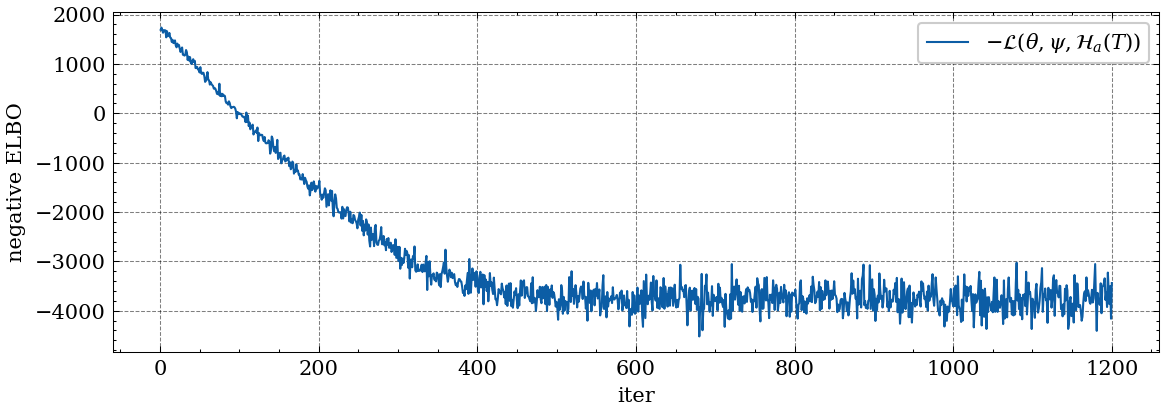

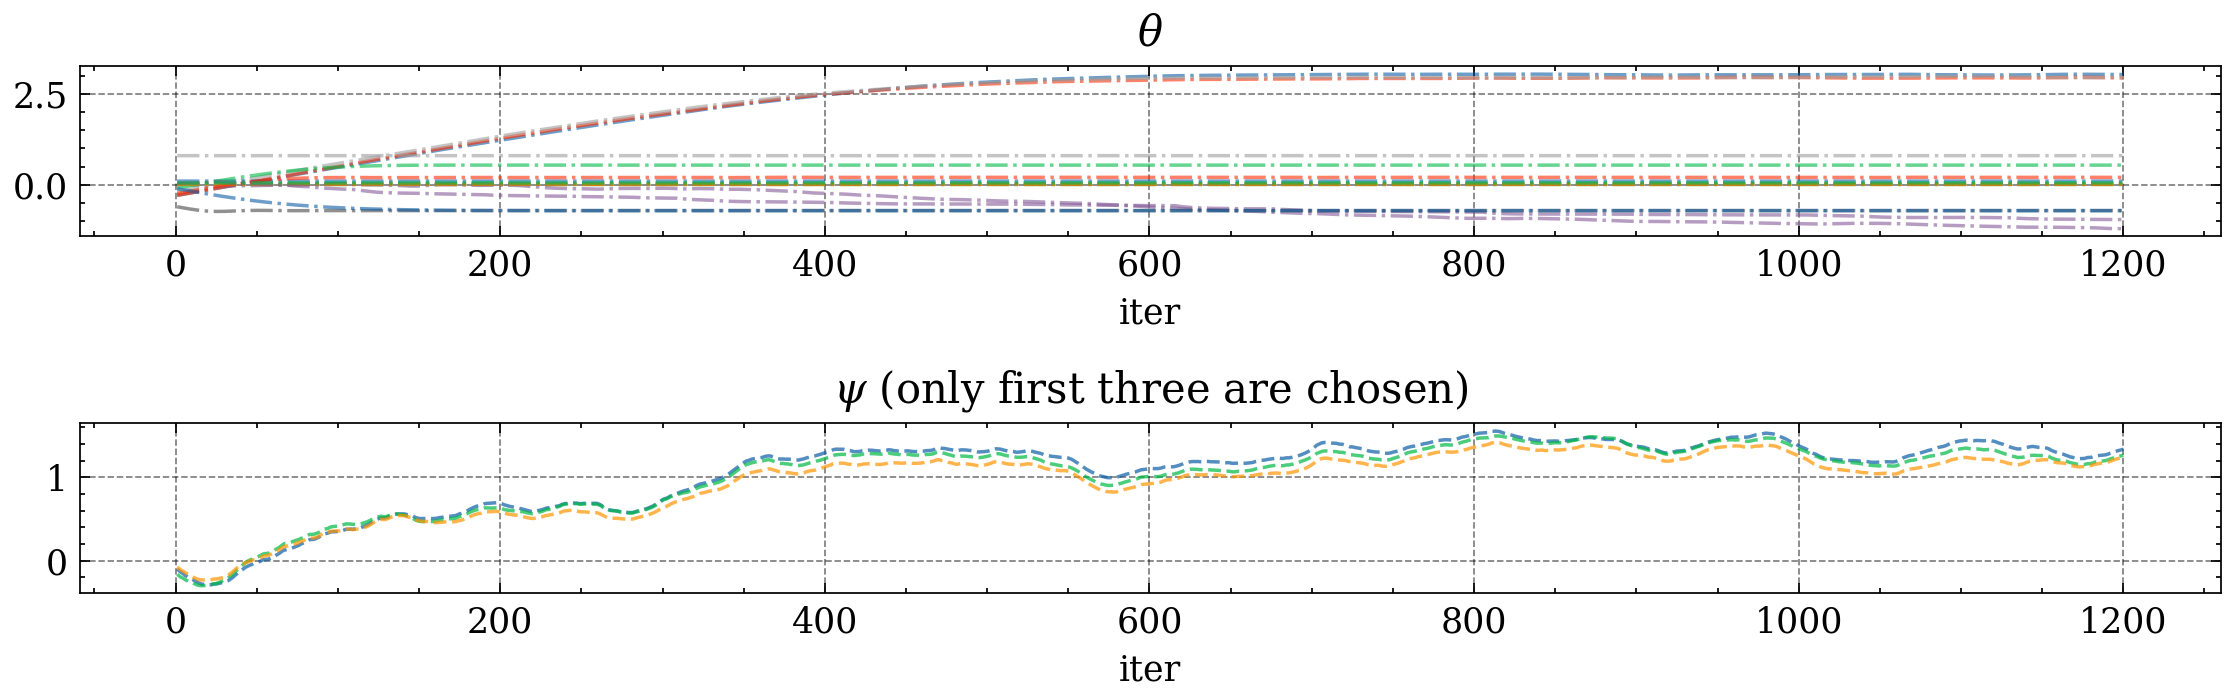

In [6]:
import warnings
warnings.filterwarnings('ignore')
learn.plot_loss(losses)

fig,ax = plt.subplots(2,1,figsize=(9,3),dpi=250)
X = np.arange(1,len(model_parameters_store)+1,1)
for i in range(len(model_parameters_store[0])):
    ax[0].plot(X,[item[i] for item in model_parameters_store],'-.',label='model param',alpha=0.6,lineWidth=1);
ax[1].plot(X,variational_parameter_store,'--',label='variational parameter',alpha=0.7);
ax[0].set_xlabel('iter'); ax[0].set_title('$\\theta$')
ax[1].set_xlabel('iter'); ax[1].set_title('$\\psi$ (only first three are chosen)')
fig.tight_layout()